# Multi-Exchange BTC/USD Data Integration & Analysis

This notebook is a comprehensive guide for integrating and processing BTC/USD OHLC (Open, High, Low, Close) data from multiple cryptocurrency exchanges to create a robust, continuous, and volume-weighted index dataset. Using data from several exchanges (e.g., Bitstamp, Coinbase, Binance), we address common data issues and outline methods for merging and smoothing time series data across exchanges. 

**Key Steps:**
1. **Data Import and Inspection:** Load OHLC data from each exchange and inspect for issues, including gaps and misalignments.
2. **Gap Analysis and Visualization:** Identify and visualize gaps in each exchange's data, highlighting challenges with using single-source data.
3. **Data Cleaning and Open-Close (OC) Alignment:** Standardize OHLC values across datasets, correct Open-Close misalignments, and ensure integrity of High/Low prices.
4. **Volume-Weighted Averaging:** Create a cohesive, market-representative index by combining exchange data, accounting for volume to reflect each exchange's influence.
5. **Imputation of Gaps:** Address gaps by using a centered moving average to maintain data continuity and reduce artificial volatility.
6. **Final Dataset Construction:** Merge all techniques to produce a final, gap-free index dataset, aligned and weighted to provide an accurate, continuous view of BTC/USD market trends.

Throughout, we illustrate each technique with code examples and visualization, culminating in a final dataset suitable for reliable time series analysis and model training.

In [1]:
import pandas as pd
import os

def load_all_datasets():
    """
    Load all datasets into a dictionary without printing any information.
    
    Returns:
        dict: Dictionary with dataset names as keys and DataFrames as values.
    """
    # Define the path to the directory where the datasets are stored
    dataset_dir = '/kaggle/input/comprehensive-btcusd-1m-data/'
    
    # Dictionary to store the loaded datasets
    datasets = {}
    
    # List of CSV files to load
    csv_files = [
        "BTCUSD_1m_Bitstamp.csv",
        "BTCUSD_1m_BitMEX.csv",
        "BTCUSD_1m_Coinbase.csv",
        "BTCUSD_1m_Binance.csv",
        "BTCUSD_1m_KuCoin.csv",
        "BTCUSD_1m_Bitfinex.csv",
        "BTCUSD_1m_OKX.csv"
    ]
    
    # Load each dataset into the dictionary
    for csv_file in csv_files:
        file_path = os.path.join(dataset_dir, csv_file)
        df = pd.read_csv(file_path)
        
        # Convert 'Open time' to datetime for consistency
        df['Open time'] = pd.to_datetime(df['Open time'])
        
        # Store the dataframe in the dictionary
        datasets[csv_file] = df
    
    return datasets


This cell loads datasets into a dictionary for easy access later. Each dataset corresponds to OHLC data (Open, High, Low, Close) from a different exchange, covering varying time ranges. By printing the ranges, we aim to identify periods where data overlap.

For example, the Bitfinex dataset begins in 2013-07, while Coinbase only starts in 2015-07. Understanding this helps us later in combining data sources effectively.

In [2]:
# Step 1: Load the datasets
datasets = load_all_datasets()

# Step 2: Print the time ranges for each dataset
for name, df in datasets.items():
    print(f"{name}: {df['Open time'].min()} to {df['Open time'].max()}")

BTCUSD_1m_Bitstamp.csv: 2011-08-18 12:37:00 to 2024-10-26 22:04:00
BTCUSD_1m_BitMEX.csv: 2015-09-25 12:35:00 to 2024-10-26 22:04:00
BTCUSD_1m_Coinbase.csv: 2015-07-20 21:37:00 to 2024-10-26 22:04:00
BTCUSD_1m_Binance.csv: 2017-08-17 04:00:00 to 2024-10-26 22:04:00
BTCUSD_1m_KuCoin.csv: 2017-12-21 00:11:00 to 2024-10-26 22:04:00
BTCUSD_1m_Bitfinex.csv: 2013-07-19 00:05:00 to 2024-10-26 22:04:00
BTCUSD_1m_OKX.csv: 2018-01-11 11:12:00 to 2024-10-26 22:03:00


# Visualizing Issues in the Bitfinex Dataset
Here, we visualize the Close values from the Bitfinex dataset between 2013-07 and 2015-07 to demonstrate issues caused by data gaps. We filter up to the start date of the Coinbase dataset. Focusing on Bitfinex highlights frequent small gaps and two large gaps that reveal potential missing data that may impact analysis and modeling.

1. First Subplot: We zoom in on the first 200 data points to visualize small gaps that occur frequently, even in a relatively short period.
1. Second Subplot: We plot the entire dataset up to the starting point of the next dataset. This gives a broader view of the data and reveals the presence of two very large gaps as well as many smaller ones.

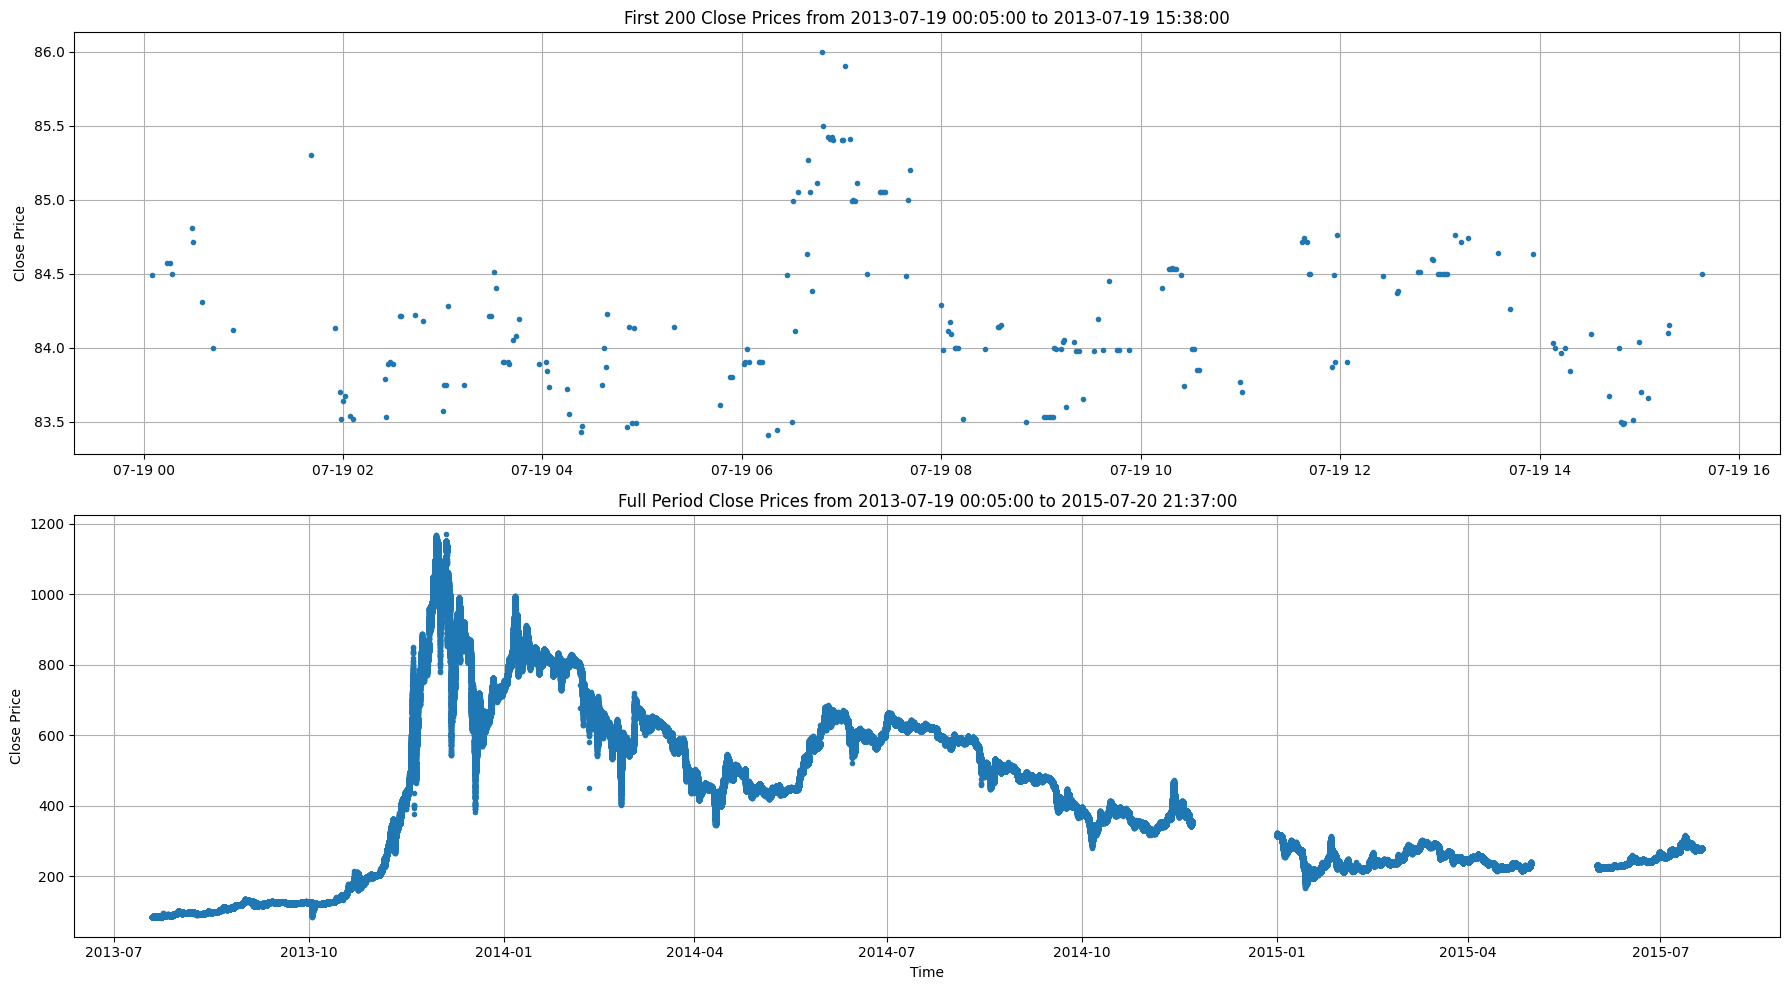



Total number of gaps: 126635


In [3]:
import matplotlib.pyplot as plt

def find_and_plot_closes_with_gaps_two_subplots(dataset, next_start_time):
    """
    Identify gaps in the time index and plot 'Close' values over time using two subplots.
    The first subplot shows the first 200 data points, and the second shows the full time period.

    Args:
        dataset (pd.DataFrame): DataFrame of the dataset to analyze.
        next_start_time (pd.Timestamp): Start time of the next dataset to define the time range.
    """
    # Filter the dataset to only include data up to the next_start_time
    filtered_data = dataset[dataset['Open time'] < next_start_time].copy()
    
    # Calculate time differences between consecutive 'Open time' entries
    filtered_data['time_diff'] = filtered_data['Open time'].diff()
    
    # Identify gaps longer than 1 minute (which is the expected frequency for 1-minute OHLC data)
    expected_frequency = pd.Timedelta(minutes=1)
    gaps = filtered_data[filtered_data['time_diff'] > expected_frequency]
    
    # Count the number of gaps
    total_gaps = len(gaps)

    # First 200 data points for the first subplot
    first_200 = filtered_data.iloc[:200]
    
    # Create subplots (2 rows, 1 column)
    fig, axes = plt.subplots(2, 1, figsize=(18, 10))

    # Plot for the first 200 data points
    axes[0].plot(first_200['Open time'], first_200['Close'], marker='.', linestyle='None')
    axes[0].set_title(f"First 200 Close Prices from {first_200['Open time'].min()} to {first_200['Open time'].max()}")
    axes[0].set_ylabel('Close Price')
    axes[0].grid(True)

    # Plot for the entire filtered dataset
    axes[1].plot(filtered_data['Open time'], filtered_data['Close'], marker='.', linestyle='None')
    axes[1].set_title(f"Full Period Close Prices from {filtered_data['Open time'].min()} to {next_start_time}")
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Close Price')
    axes[1].grid(True)

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()
    
    print(f"\n\nTotal number of gaps: {total_gaps}")

# Define the earliest dataset and next dataset's start time
bitfinex_data = datasets['BTCUSD_1m_Bitfinex.csv']
coinbase_start_time = datasets['BTCUSD_1m_Coinbase.csv']['Open time'].min()

# Call the function to count gaps and plot the Close prices with 2 subplots
find_and_plot_closes_with_gaps_two_subplots(bitfinex_data, coinbase_start_time)


We identify a total of 126,635 gaps in this period, which underscores the challenge of working with data from a single source. Gaps can occur due to various reasons, including exchange downtime or data collection issues. These gaps result in incomplete information, which can impact analysis or modeling.

# Inspecting the Next Period with Two Exchanges

In this section, we are going to analyze a new period of data using two exchanges: Bitfinex and Coinbase. This period starts from the moment Coinbase data becomes available (2015-07-21) and ends when Binance data starts (2017-08-17).

We will inspect this time period in the same way we did previously:

1.     First, we will identify any gaps in both datasets by calculating the differences between consecutive time entries. Gaps are recorded when the time difference is greater than the expected 1-minute interval.
1.     Second, we will create two plots for each dataset:
    *         The first plot shows the first 200 data points for a zoomed-in view.
    *         The second plot displays the entire period to give an overview of how gaps and price trends evolve over time.
   
**Gaps in the Data**

Just like in the previous period (where we only had one exchange), we expect to find gaps in both Bitfinex and Coinbase data. These gaps might be caused by exchange downtime or missing data. We will print the total number of gaps found in each dataset.

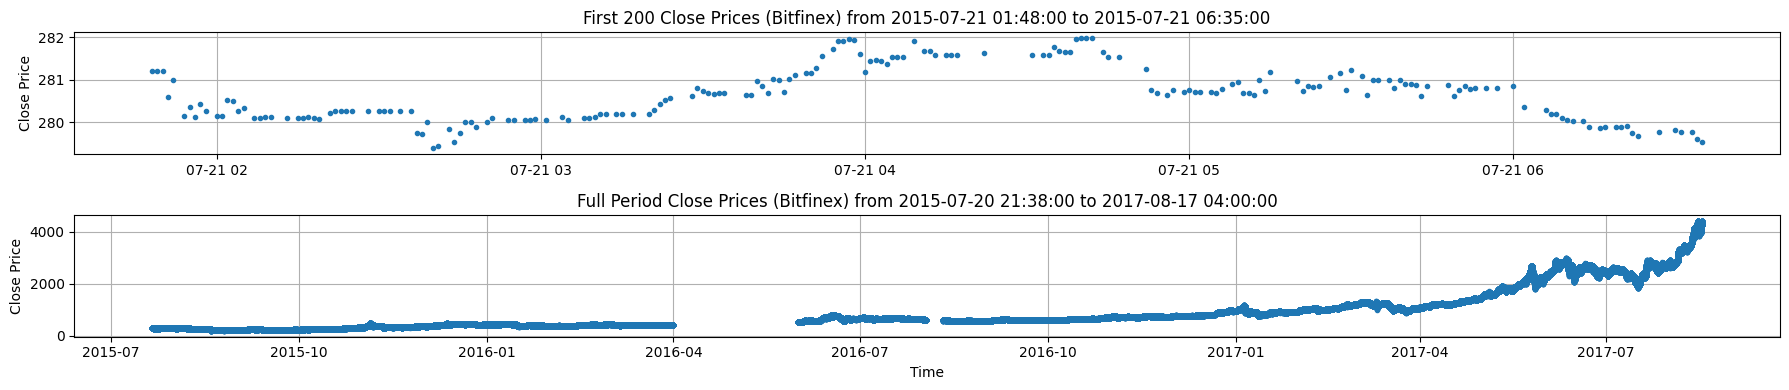

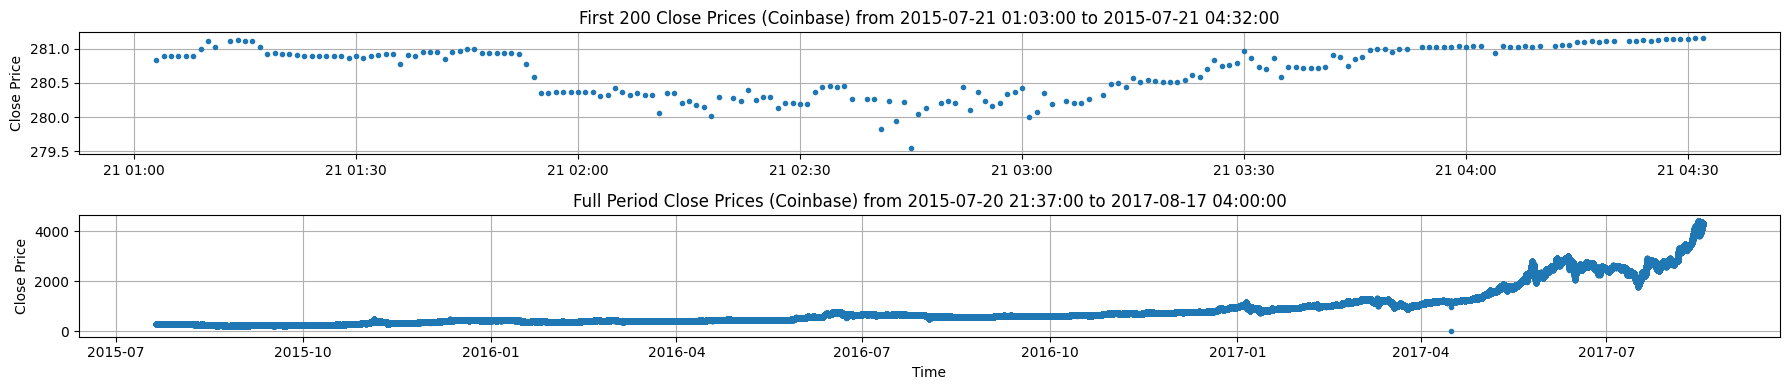



Total number of gaps in Bitfinex: 111913
Total number of gaps in Coinbase: 39132


In [4]:
def find_and_plot_gaps_for_two_exchanges(dataset1, dataset2, start_time, end_time, start_index=0):
    """
    Identify gaps in the time index and plot 'Close' values over time using two subplots for two datasets.
    The first subplot shows the first 200 data points, and the second shows the full time period.

    Args:
        dataset1 (pd.DataFrame): First DataFrame to analyze.
        dataset2 (pd.DataFrame): Second DataFrame to analyze.
        start_time (pd.Timestamp): Start time of the period to analyze.
        end_time (pd.Timestamp): End time of the period to analyze.
        start_index (int): Index to start the 200-point subset.
    """
    # Filter both datasets to the specified time range
    filtered_data1 = dataset1[(dataset1['Open time'] >= start_time) & (dataset1['Open time'] < end_time)].copy()
    filtered_data2 = dataset2[(dataset2['Open time'] >= start_time) & (dataset2['Open time'] < end_time)].copy()
    
    # Calculate time differences between consecutive 'Open time' entries for both datasets
    filtered_data1['time_diff'] = filtered_data1['Open time'].diff()
    filtered_data2['time_diff'] = filtered_data2['Open time'].diff()
    
    # Identify gaps longer than 1 minute for both datasets
    expected_frequency = pd.Timedelta(minutes=1)
    gaps1 = filtered_data1[filtered_data1['time_diff'] > expected_frequency]
    gaps2 = filtered_data2[filtered_data2['time_diff'] > expected_frequency]
    
    # Count the number of gaps in both datasets
    total_gaps1 = len(gaps1)
    total_gaps2 = len(gaps2)
    
    # First 200 data points for each dataset, starting from start_index
    first_200_data1 = filtered_data1.iloc[start_index:start_index+200]
    first_200_data2 = filtered_data2.iloc[start_index:start_index+200]
    
    # Create subplots (2 rows, 1 column) for Bitfinex data
    fig, axes = plt.subplots(2, 1, figsize=(18, 4))

    # Plot for the first 200 data points (Bitfinex)
    axes[0].plot(first_200_data1['Open time'], first_200_data1['Close'], marker='.', linestyle='None')
    axes[0].set_title(f"First 200 Close Prices (Bitfinex) from {first_200_data1['Open time'].min()} to {first_200_data1['Open time'].max()}")
    axes[0].set_ylabel('Close Price')
    axes[0].grid(True)

    # Plot for the entire dataset (Bitfinex)
    axes[1].plot(filtered_data1['Open time'], filtered_data1['Close'], marker='.', linestyle='None')
    axes[1].set_title(f"Full Period Close Prices (Bitfinex) from {filtered_data1['Open time'].min()} to {end_time}")
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Close Price')
    axes[1].grid(True)

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

    # Create subplots (2 rows, 1 column) for Coinbase data
    fig, axes = plt.subplots(2, 1, figsize=(18, 4))

    # Plot for the first 200 data points (Coinbase)
    axes[0].plot(first_200_data2['Open time'], first_200_data2['Close'], marker='.', linestyle='None')
    axes[0].set_title(f"First 200 Close Prices (Coinbase) from {first_200_data2['Open time'].min()} to {first_200_data2['Open time'].max()}")
    axes[0].set_ylabel('Close Price')
    axes[0].grid(True)

    # Plot for the entire dataset (Coinbase)
    axes[1].plot(filtered_data2['Open time'], filtered_data2['Close'], marker='.', linestyle='None')
    axes[1].set_title(f"Full Period Close Prices (Coinbase) from {filtered_data2['Open time'].min()} to {end_time}")
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Close Price')
    axes[1].grid(True)

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

    print(f"\n\nTotal number of gaps in Bitfinex: {total_gaps1}")
    print(f"Total number of gaps in Coinbase: {total_gaps2}")
    
# Define the start and end times for the period of interest
coinbase_first_timestamp = datasets['BTCUSD_1m_Coinbase.csv']['Open time'].min() # Coinbase's start time
binance_first_timestamp = datasets['BTCUSD_1m_Binance.csv']['Open time'].min()   # Binance's start time

# Define the datasets for Coinbase, as we did for Bitfinex in the previous cell
coinbase_data = datasets['BTCUSD_1m_Coinbase.csv']

# Call the function to find gaps and plot the Close prices for both datasets, allowing the start index to be customized
find_and_plot_gaps_for_two_exchanges(bitfinex_data, coinbase_data, coinbase_first_timestamp, binance_first_timestamp, start_index=200)


# Averaging Data from Multiple Exchanges

As you can see in the above plots, there are numerous gaps in both Bitfinex and Coinbase's datasets, the next step will be to combine or average these two datasets using a simple mean for clarity at first. The goal of this is to mitigate the impact of gaps in any one exchange by filling in missing data with information from the other exchange. However, as we'll find out, whilst we may deal with the gaps, averaging two exchanges at such an early period comes with its own issues, which we'll identify and tackle later in the notebook. Exchanges this early often have price mismatches, whilst often not being too far apart, the difference is still larger than at later periods.

Averaging prices from multiple exchanges offers three key benefits:

*     Fills gaps in one dataset with data from another exchange, creating a more continuous data stream.
*     Improves reliability by drawing on multiple exchanges to capture a holistic market view.
*     Enables us to assess true market volume by considering all exchange volumes.

Together, these factors create a cleaner, more reliable dataset for analysis and prediction.

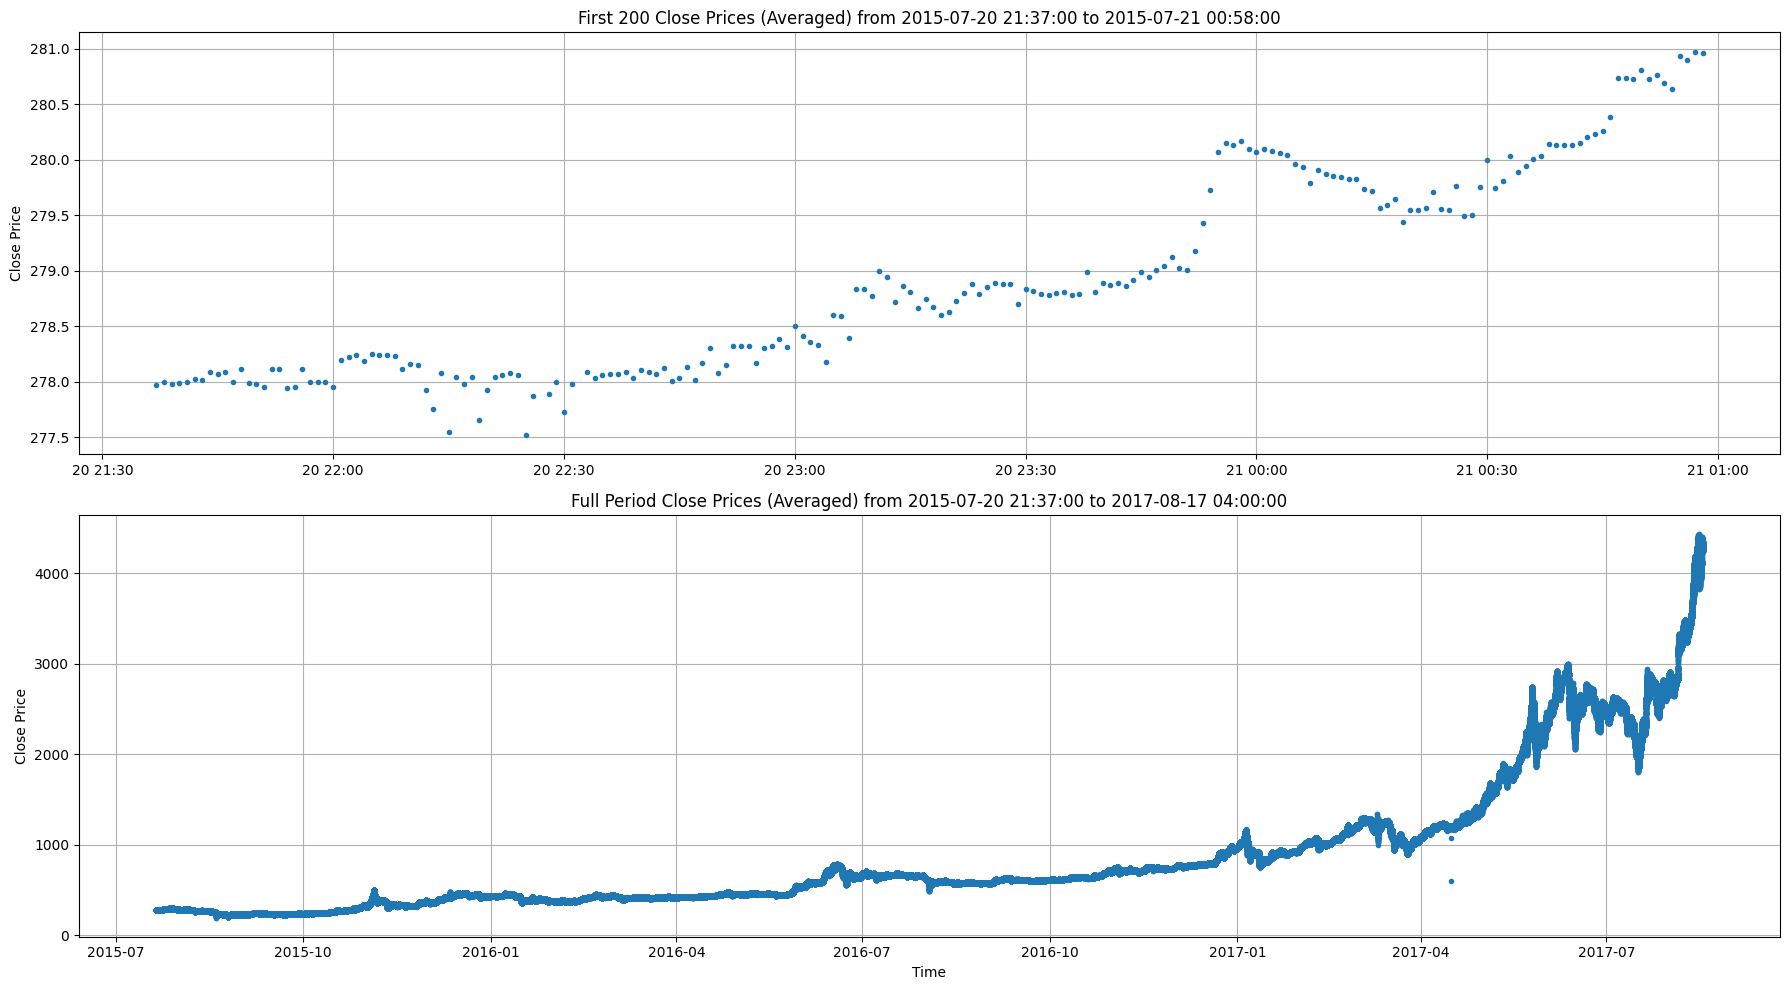

Total number of gaps in the averaged dataset: 17940
The last gap ends at: 2017-07-10 03:16:00


In [5]:
def average_datasets_with_simple_mean(dataset1, dataset2, start_time, end_time):
    """
    Take the mean of the 'Open', 'High', 'Low', and 'Close' values for each timestep 
    across the two datasets within the specified time range, using simple mean for each
    column and handling missing data (NaNs).
    
    Args:
        dataset1 (pd.DataFrame): First DataFrame to average.
        dataset2 (pd.DataFrame): Second DataFrame to average.
        start_time (pd.Timestamp): Start time of the period to analyze.
        end_time (pd.Timestamp): End time of the period to analyze.
    """
    # Filter both datasets to the specified time range
    filtered_data1 = dataset1[(dataset1['Open time'] >= start_time) & (dataset1['Open time'] < end_time)].copy()
    filtered_data2 = dataset2[(dataset2['Open time'] >= start_time) & (dataset2['Open time'] < end_time)].copy()
    
    # Set 'Open time' as index to facilitate merging on time
    filtered_data1.set_index('Open time', inplace=True)
    filtered_data2.set_index('Open time', inplace=True)
    
    # Merge the datasets on 'Open time' and use 'outer' join to include all timestamps
    combined_data = pd.concat([filtered_data1, filtered_data2], axis=1, keys=['Dataset1', 'Dataset2'], join='outer')
    
    # Take the mean of the columns 'Open', 'High', 'Low', 'Close', handling NaNs
    averaged_data = pd.DataFrame(index=combined_data.index)
    averaged_data['Open'] = combined_data.xs('Open', axis=1, level=1).mean(axis=1)
    averaged_data['High'] = combined_data.xs('High', axis=1, level=1).mean(axis=1)
    averaged_data['Low'] = combined_data.xs('Low', axis=1, level=1).mean(axis=1)
    averaged_data['Close'] = combined_data.xs('Close', axis=1, level=1).mean(axis=1)
    
    # Reindex the time to calculate gaps
    averaged_data.reset_index(inplace=True)
    averaged_data['time_diff'] = averaged_data['Open time'].diff()
    
    # Identify gaps longer than 1 minute
    expected_frequency = pd.Timedelta(minutes=1)
    gaps = averaged_data[averaged_data['time_diff'] > expected_frequency]
    
    # Plot the averaged data
    fig, axes = plt.subplots(2, 1, figsize=(18, 10))

    # First 200 data points
    first_200 = averaged_data.iloc[:200]
    axes[0].plot(first_200['Open time'], first_200['Close'], marker='.', linestyle='None')
    axes[0].set_title(f"First 200 Close Prices (Averaged) from {first_200['Open time'].min()} to {first_200['Open time'].max()}")
    axes[0].set_ylabel('Close Price')
    axes[0].grid(True)

    # Full time period
    axes[1].plot(averaged_data['Open time'], averaged_data['Close'], marker='.', linestyle='None')
    axes[1].set_title(f"Full Period Close Prices (Averaged) from {averaged_data['Open time'].min()} to {end_time}")
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Close Price')
    axes[1].grid(True)

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()
    
    # Count the number of gaps
    total_gaps = len(gaps)
    
    print(f"Total number of gaps in the averaged dataset: {total_gaps}")
    
    # If there are gaps, print the Open time of when the last gap ends
    if total_gaps > 0:
        last_gap_index = gaps.index[-1] + 1
        if last_gap_index < len(averaged_data):
            last_gap_end_time = averaged_data.loc[last_gap_index, 'Open time']
            print(f"The last gap ends at: {last_gap_end_time}")
        else:
            print("The last gap reaches the end of the dataset.")


# Call the function to take the average of the two datasets and plot the results, we are going from Coinbase's first timestamp to Binance's
average_datasets_with_simple_mean(bitfinex_data, coinbase_data, coinbase_first_timestamp, binance_first_timestamp)

As you can see above, by averaging the datasets together, we've eliminated more than half of the gaps going from 39127 to 17938. Now we'll write a more general function to take multiple datasets and average all of them together so we can include Bitstamp.

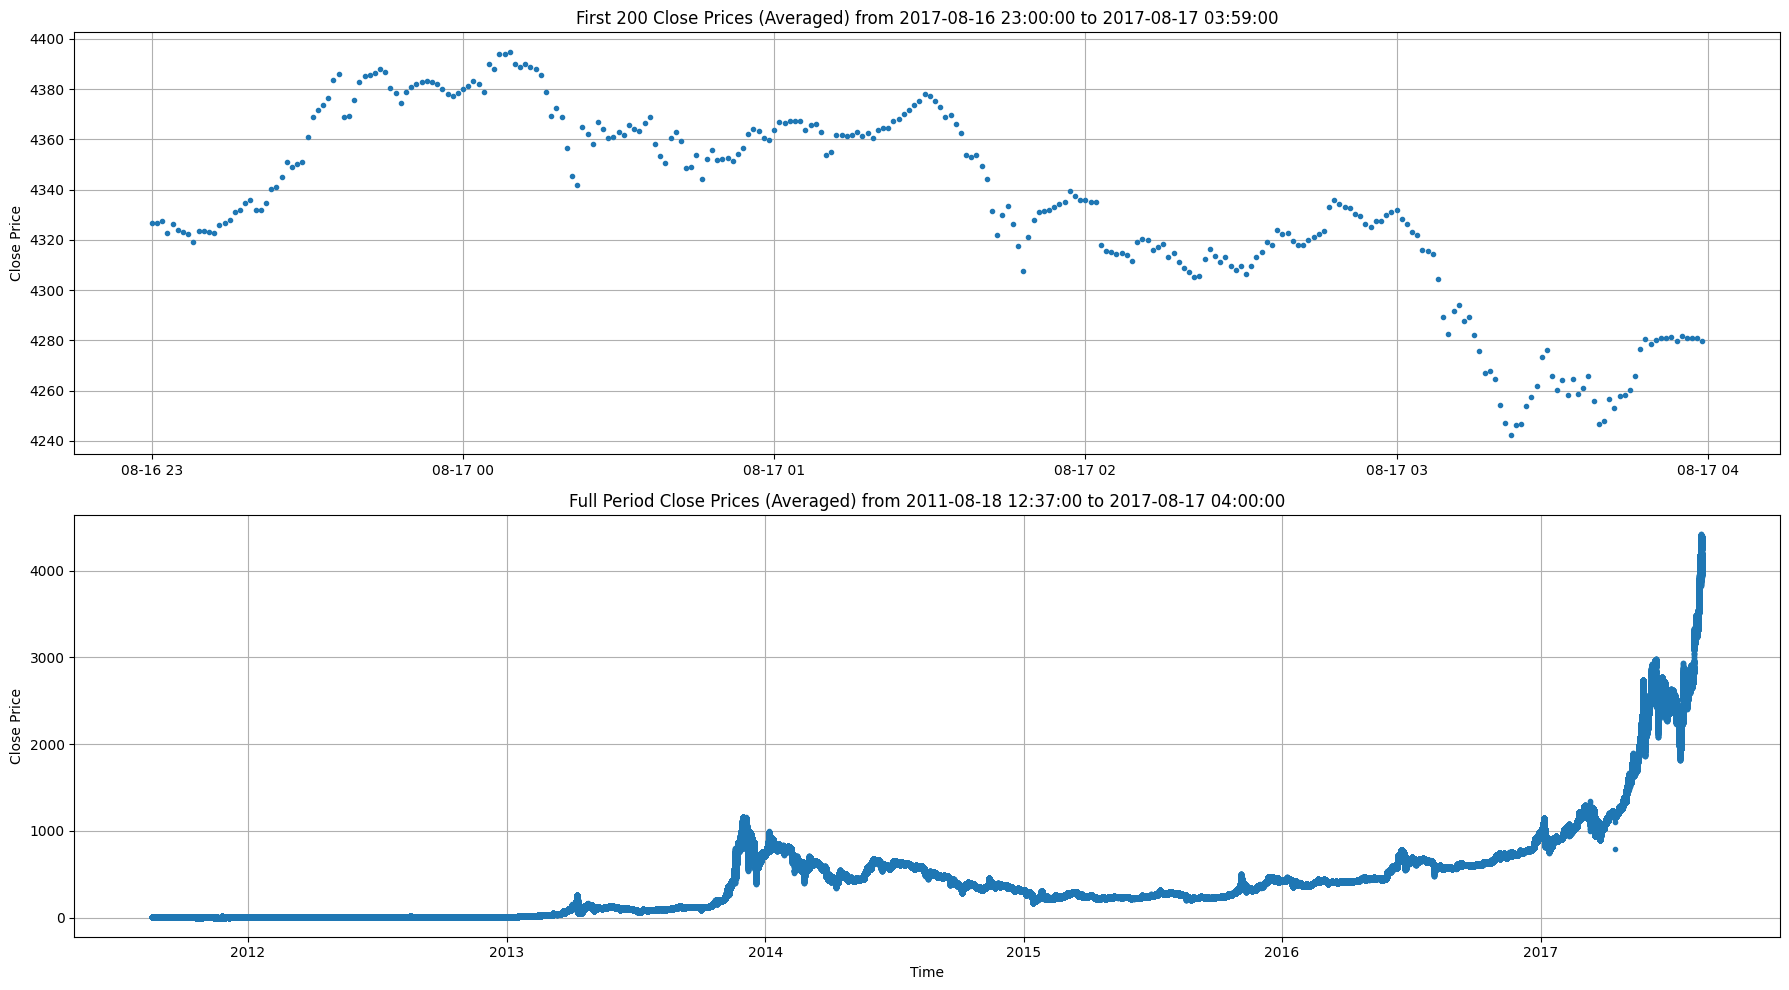

Total number of gaps in the averaged dataset: 0


In [6]:
def average_datasets_with_simple_mean(datasets, start_time, end_time):
    """
    Take the mean of the 'Open', 'High', 'Low', and 'Close' values for each timestep 
    across multiple datasets within the specified time range, using simple mean for each
    column and handling missing data (NaNs).
    
    Args:
        datasets (list of pd.DataFrame): List of DataFrames to average.
        start_time (pd.Timestamp): Start time of the period to analyze.
        end_time (pd.Timestamp): End time of the period to analyze.
    
    Returns:
        pd.DataFrame: The averaged data for the entire time period.
        pd.DataFrame: The first 200 rows of averaged data for comparison in another plot.
    """
    # Filter each dataset to the specified time range and set 'Open time' as index
    filtered_data_list = []
    for i, dataset in enumerate(datasets):
        filtered_data = dataset[(dataset['Open time'] >= start_time) & (dataset['Open time'] < end_time)].copy()
        filtered_data.set_index('Open time', inplace=True)
        filtered_data_list.append(filtered_data)
    
    # Merge all datasets on 'Open time' with an outer join to include all timestamps
    combined_data = pd.concat(filtered_data_list, axis=1, keys=[f'Dataset_{i+1}' for i in range(len(datasets))], join='outer')
    
    # Calculate the mean for 'Open', 'High', 'Low', and 'Close' columns across all datasets, handling NaNs
    averaged_data = pd.DataFrame(index=combined_data.index)
    for col in ['Open', 'High', 'Low', 'Close']:
        averaged_data[col] = combined_data.xs(col, axis=1, level=1).mean(axis=1)
        
    # Reindex the time to calculate gaps
    averaged_data.reset_index(inplace=True)
    averaged_data['time_diff'] = averaged_data['Open time'].diff()
    
    # Identify gaps longer than 1 minute
    expected_frequency = pd.Timedelta(minutes=1)
    gaps = averaged_data[averaged_data['time_diff'] > expected_frequency]
    
    # Extract and save the first 200 data points for comparison in other plots
    final_300 = averaged_data.iloc[-300:].copy()
    
    # Plot the averaged data
    fig, axes = plt.subplots(2, 1, figsize=(18, 10))

    # First 200 data points
    axes[0].plot(final_300['Open time'], final_300['Close'], marker='.', linestyle='None')
    axes[0].set_title(f"First 200 Close Prices (Averaged) from {final_300['Open time'].min()} to {final_300['Open time'].max()}")
    axes[0].set_ylabel('Close Price')
    axes[0].grid(True)

    # Full time period
    axes[1].plot(averaged_data['Open time'], averaged_data['Close'], marker='.', linestyle='None')
    axes[1].set_title(f"Full Period Close Prices (Averaged) from {averaged_data['Open time'].min()} to {end_time}")
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Close Price')
    axes[1].grid(True)

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

    # Count the number of gaps
    total_gaps = len(gaps)
    
    print(f"Total number of gaps in the averaged dataset: {total_gaps}")
    
    return averaged_data, final_300

bitstamp_data = datasets['BTCUSD_1m_Bitstamp.csv']
bitstamp_first_timestamp = datasets['BTCUSD_1m_Bitstamp.csv']['Open time'].min()   # Bitstamp's start time

# Function to take the average of multiple datasets and plot the results, we return the results here to compare with later averaging plots
datasets_to_average = [bitstamp_data, bitfinex_data, coinbase_data] 
average_data_simple, final_300_simple = average_datasets_with_simple_mean(datasets_to_average, bitstamp_first_timestamp, binance_first_timestamp)

Using the Bitstamp data, we have eliminated all gaps in the data. However, take note of the extreme downward single point after 2017, this one is the most obvious erroneous values and on top of this one, there are unfortunately many similar points throughout the period plotted here. We will see how to handle such issues and provide a justification in the following section.

# Using a Volume Weighted Average on OHLC Data

**Simple Averaging vs. Weighted Averaging**

One of the primary issues with taking a simple average of OHLC data is that it does not account for volume differences between exchanges. Each exchange handles a varying amount of trading volume, which directly affects the reliability and relevance of its pricing data. A simple average treats all exchanges as equally influential, but in reality, an exchange with higher trading volume should have a more significant impact on the average price.

Weighted averaging, which factors in trading volume, is a more appropriate method for combining data because it adjusts for the importance of each exchange’s contribution. By weighting each exchange’s OHLC values by its trading volume, we ensure that exchanges with higher market activity have a greater influence on the final dataset, which more accurately reflects the overall market.

At first, we will include only the exchanges we've already used for the period we've investigated just to see the results for comparison purposes with our simple mean.

**IMPORTANT EDGE CASE:**

When multiple exchanges have zero volume in a candle, dividing by this will cause NaN values. So, the solution is to use panda's mean function to average for these locations only, this allows us to use weighted averages where appropriate i.e. candles with volume. Whilst at the same time, using simple mean averaging for cases where there is zero volume. As you'll see below, we can use a simple dataframe mask to find these locations.

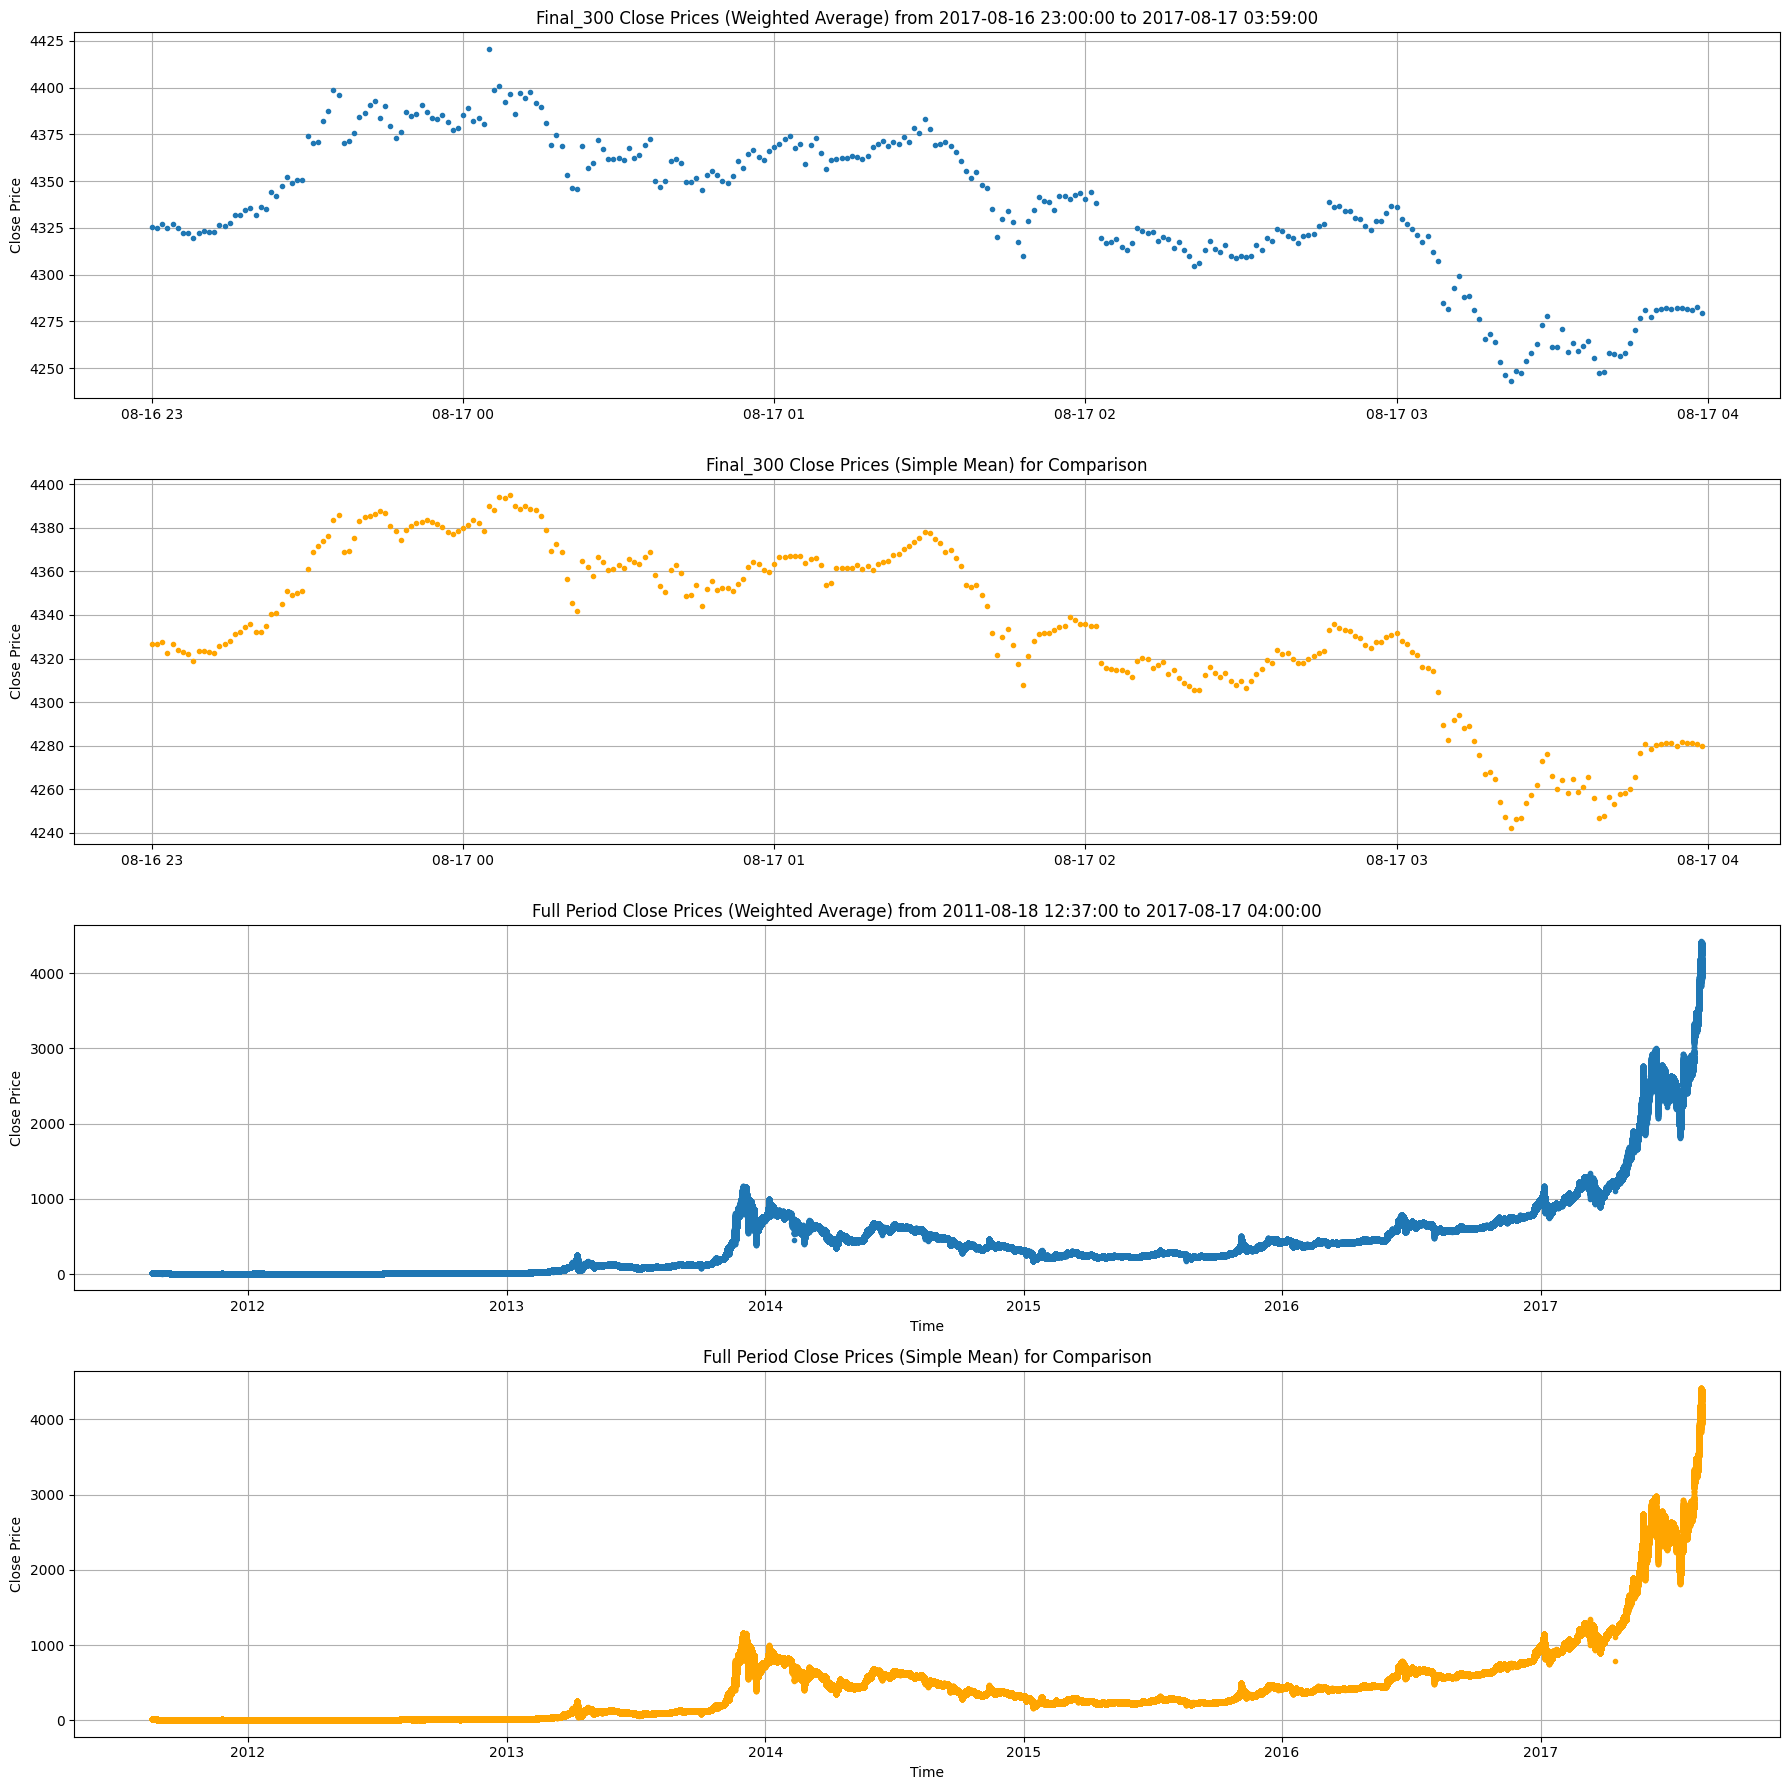

In [7]:
def average_datasets_with_weighted_mean(datasets, start_time, end_time, final_300_simple, simple_mean_full):
    """
    Take the weighted mean of the 'Open', 'High', 'Low', and 'Close' values for each timestep 
    across multiple datasets within the specified time range, using the volume as the weight.
    If the weighted mean calculation yields NaNs (due to zero volume), imputes those values 
    with the simple mean for that timestep.
    
    Args:
        datasets (list of pd.DataFrame): List of DataFrames to average.
        start_time (pd.Timestamp): Start time of the period to analyze.
        end_time (pd.Timestamp): End time of the period to analyze.
        simple_mean_first_200 (pd.DataFrame): First 200 rows of simple mean data for comparison in plot.
        simple_mean_full (pd.DataFrame): Full period of simple mean data for comparison in plot.
    
    Returns:
        pd.DataFrame: The averaged data for the entire time period.
    """
    # Filter each dataset to the specified time range and set 'Open time' as index
    filtered_data_list = []
    for i, dataset in enumerate(datasets):
        filtered_data = dataset[(dataset['Open time'] >= start_time) & (dataset['Open time'] < end_time)].copy()
        filtered_data.set_index('Open time', inplace=True)
        filtered_data_list.append(filtered_data)
    
    # Merge all datasets on 'Open time' with an outer join to include all timestamps
    combined_data = pd.concat(filtered_data_list, axis=1, keys=[f'Dataset_{i+1}' for i in range(len(datasets))], join='outer')
    
    # Calculate the weighted mean for 'Open', 'High', 'Low', and 'Close' columns across all datasets, handling NaNs
    averaged_data = pd.DataFrame(index=combined_data.index)
    for col in ['Open', 'High', 'Low', 'Close']:
        ohlc_columns = combined_data.xs(col, axis=1, level=1)
        volume_columns = combined_data.xs('Volume', axis=1, level=1)
        weighted_avg = (ohlc_columns * volume_columns).sum(axis=1) / volume_columns.sum(axis=1)
        averaged_data[col] = weighted_avg
    
    # Impute NaNs with simple mean if weighted average calculation results in NaNs
    for col in ['Open', 'High', 'Low', 'Close']:
        nan_rows = averaged_data[col].isna()
        if nan_rows.any():
            simple_mean = combined_data.xs(col, axis=1, level=1).mean(axis=1)
            averaged_data.loc[nan_rows, col] = simple_mean[nan_rows]
    
    # Reset the index for plotting
    averaged_data.reset_index(inplace=True)
    
    # Plot the averaged data with additional subplots for simple mean comparison
    fig, axes = plt.subplots(4, 1, figsize=(18, 18))

    # Final_300 data points from weighted average
    final_300 = averaged_data.iloc[-300:]
    axes[0].plot(final_300['Open time'], final_300['Close'], marker='.', linestyle='None')
    axes[0].set_title(f"Final_300 Close Prices (Weighted Average) from {final_300['Open time'].min()} to {final_300['Open time'].max()}")
    axes[0].set_ylabel('Close Price')
    axes[0].grid(True)

    # Final 300 data points from simple mean for comparison
    axes[1].plot(final_300_simple['Open time'], final_300_simple['Close'], marker='.', linestyle='None', color='orange')
    axes[1].set_title("Final_300 Close Prices (Simple Mean) for Comparison")
    axes[1].set_ylabel('Close Price')
    axes[1].grid(True)

    # Full time period from weighted average
    axes[2].plot(averaged_data['Open time'], averaged_data['Close'], marker='.', linestyle='None')
    axes[2].set_title(f"Full Period Close Prices (Weighted Average) from {averaged_data['Open time'].min()} to {end_time}")
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Close Price')
    axes[2].grid(True)

    # Full time period from simple mean for comparison
    axes[3].plot(simple_mean_full['Open time'], simple_mean_full['Close'], marker='.', linestyle='None', color='orange')
    axes[3].set_title("Full Period Close Prices (Simple Mean) for Comparison")
    axes[3].set_xlabel('Time')
    axes[3].set_ylabel('Close Price')
    axes[3].grid(True)

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()
    
    return averaged_data


weighted_averaged_data = average_datasets_with_weighted_mean(datasets_to_average, bitstamp_first_timestamp, binance_first_timestamp, final_300_simple, average_data_simple)

As you can see from the above, the overall profile looks mostly the same, however, there are regions where spikes occur in the weighted average, whilst smoothing occurs at other parts. Significantly, in the whole time period plot, the seemingly erroneous price drop after the 2017-04 index has been eliminated. The weighted average, whilst introducing some more volatility at parts, overall smooths the data and is the more complete and correct picture of the market, as we have taken account of the volume in each price movement. The points of new volatility are important as they represent sections of market movement with large volume i.e. legitimate price movements and a market dynamic we'd want a machine learning model to pick up on when correlating high volume in a candle with a large volatile price movement.

# Introducing a Generalized Diagnostic Function

As we work with various transformations and combinations of datasets, it's crucial to maintain the quality and integrity of our data. To help us quickly assess the health of any dataset after applying transformations, I’ve written a generalized diagnostic function, dataframe_diagnostics. This function allows us to spot common data quality issues, such as:

*     Missing values (NaNs): Missing data can distort any subsequent analysis or models we create.
*     Time gaps: Since we're dealing with time series data, we expect a uniform 1-minute spacing between each row. This tool will help us identify any gaps in the time index.
*     Duplicate rows: Duplicated rows may inadvertently occur during merging or transformation processes, potentially skewing results.
*     Integrity of High and Low values: whether the values in the 'High/Low' columns are actually the 'largest/smallest' value within OHLC.

By applying this tool to our datasets after each significant transformation, we can ensure that any issues are caught early, allowing for more robust data processing. This function will print a clear diagnostic report that highlights any issues in the data, and it is flexible enough to be used across different time series datasets, feel free to use this for any other datasets.

In [8]:
def dataframe_diagnostics(df, max_gaps_to_print=5):
    """
    Diagnostic function to check for NaNs, duplicates, and time gaps in a 1-minute timeframe dataset.
    This function prints diagnostics by default. If there are more than 'max_gaps_to_print' gaps, it will
    print only the first 'max_gaps_to_print' and redact the rest for conciseness.
    
    Parameters:
    - df: The pandas DataFrame to diagnose.
    - max_gaps_to_print: The maximum number of gaps to print (default is 5).
    """
    
    # Convert 'Open time' to datetime format.
    # This ensures we can calculate time differences properly between rows.
    df['Open time'] = pd.to_datetime(df['Open time'], errors='coerce')

    # Basic information gathering:
    # - Calculate the size of the dataset.
    # - Count total NaN (missing) values across the entire dataset.
    # - Identify which columns contain NaNs and how many rows have missing data.
    size = len(df)
    total_nans = df.isna().sum().sum()
    nan_cols = df.isna().sum()[df.isna().sum() > 0].index.tolist()
    rows_with_nans = df.isna().any(axis=1).sum()

    # Detect time gaps:
    # For a 1-minute timeframe dataset, we expect consecutive rows to have a 1-minute difference.
    # We calculate the actual time differences and flag any that are not exactly 1 minute.
    expected_diff = pd.Timedelta(minutes=1)
    time_diffs = df['Open time'].diff().dropna()
    discontinuities = time_diffs[time_diffs != expected_diff].index.tolist()

    # Capture details of detected time gaps:
    # For each gap, record the start time, end time, and the size of the gap.
    gap_details = []
    if len(discontinuities) > 0:
        for gap_index in discontinuities:
            gap_start_index = gap_index - 1
            gap_end_index = gap_index
            gap_start_time = df['Open time'].iloc[gap_start_index]
            gap_end_time = df['Open time'].iloc[gap_end_index]
            gap_size = gap_end_time - gap_start_time

            gap_details.append({
                'Start Index': gap_start_index,
                'End Index': gap_end_index,
                'Start Time': gap_start_time,
                'End Time': gap_end_time,
                'Gap Size': gap_size
            })

    # Detect duplicate rows:
    # Any rows that have identical data across all columns are flagged as duplicates.
    duplicate_rows = df[df.duplicated(keep=False)]
    num_duplicate_rows = len(duplicate_rows)

    # Print the diagnostics summary:
    print(f"--- DataFrame Diagnostics ---")
    print(f"Start 'Open time': {df['Open time'].iloc[0]}, End 'Open time': {df['Open time'].iloc[-1]}")
    print(f"Size: {size} rows")
    print(f"Total NaNs: {total_nans}")
    print(f"Columns with NaNs: {nan_cols if nan_cols else 'None'}")
    print(f"Rows with NaNs: {rows_with_nans}")
    print(f"Number of discontinuities in 'Open time': {len(discontinuities)}")

    if gap_details:
        first_gap_start = gap_details[0]['Start Time']
        last_gap_end = gap_details[-1]['End Time']
        print(f"Discontinuities range from 'Open time': {first_gap_start} to 'Open time': {last_gap_end}")

    print(f"Number of duplicate rows: {num_duplicate_rows}")

    # Print gaps if any, but limit to max_gaps_to_print.
    if gap_details:
        print(f"\nDetected {len(gap_details)} data gaps:")
        for i, gap in enumerate(gap_details[:max_gaps_to_print]):
            print(f"Gap {i+1}: Start Time {gap['Start Time']}, End Time {gap['End Time']}, Gap Size: {gap['Gap Size']}")
        
        # If there are more gaps than the max_gaps_to_print, redact the remaining gaps to prevent too much output.
        if len(gap_details) > max_gaps_to_print:
            print(f"... and {len(gap_details) - max_gaps_to_print} more gaps are redacted for conciseness.")
    
    # If there are duplicate rows, print the duplicate rows.
    if num_duplicate_rows > 0:
        print("\nDetected duplicate rows:")
        print(duplicate_rows)

    ohlc_columns = ['Open', 'High', 'Low', 'Close']
    
    # Check for invalid 'High' values:
    # High should always be greater than or equal to the maximum of Open, Close, and Low.
    # We filter rows where High is less than any of these values.
    invalid_high = df[df['High'] < df[['Open', 'Close', 'Low']].max(axis=1)]
    
    # Check for invalid 'Low' values:
    # Low should always be less than or equal to the minimum of Open, Close, and High.
    # We filter rows where Low is greater than any of these values.
    invalid_low = df[df['Low'] > df[['Open', 'Close', 'High']].min(axis=1)]

    # Print the results of the OHLC integrity check:
    # This section prints out how many rows had invalid 'High' and 'Low' values.
    # This is important because it helps catch cases where prices may have been swapped or misrecorded.
    print("\n--- OHLC Integrity Check ---")
    print(f"Invalid 'High' values: {len(invalid_high)} rows")
    print(f"Invalid 'Low' values: {len(invalid_low)} rows")

#combined_data = datasets['BTCUSD_1m_Combined_Index.csv']
dataframe_diagnostics(weighted_averaged_data, max_gaps_to_print=5)

--- DataFrame Diagnostics ---
Start 'Open time': 2011-08-18 12:37:00, End 'Open time': 2017-08-17 03:59:00
Size: 3154523 rows
Total NaNs: 0
Columns with NaNs: None
Rows with NaNs: 0
Number of discontinuities in 'Open time': 0
Number of duplicate rows: 0

--- OHLC Integrity Check ---
Invalid 'High' values: 0 rows
Invalid 'Low' values: 0 rows


# Visualizing OHLC Data as a Candlestick Chart

Beyond diagnostics, visualizing OHLC data as a standard candlestick chart allows us to spot issues and irregularities that may otherwise go unnoticed. Here, we plot Coinbase’s OHLC data to see what good data looks like. Later, we’ll extend this approach to include other exchanges and see an example of bad data in comparison and how we can fix it.

For OHLC plots we will make use of the mplfinance module, which will need to be pip installed in our environment first.

In [9]:
!pip install mplfinance

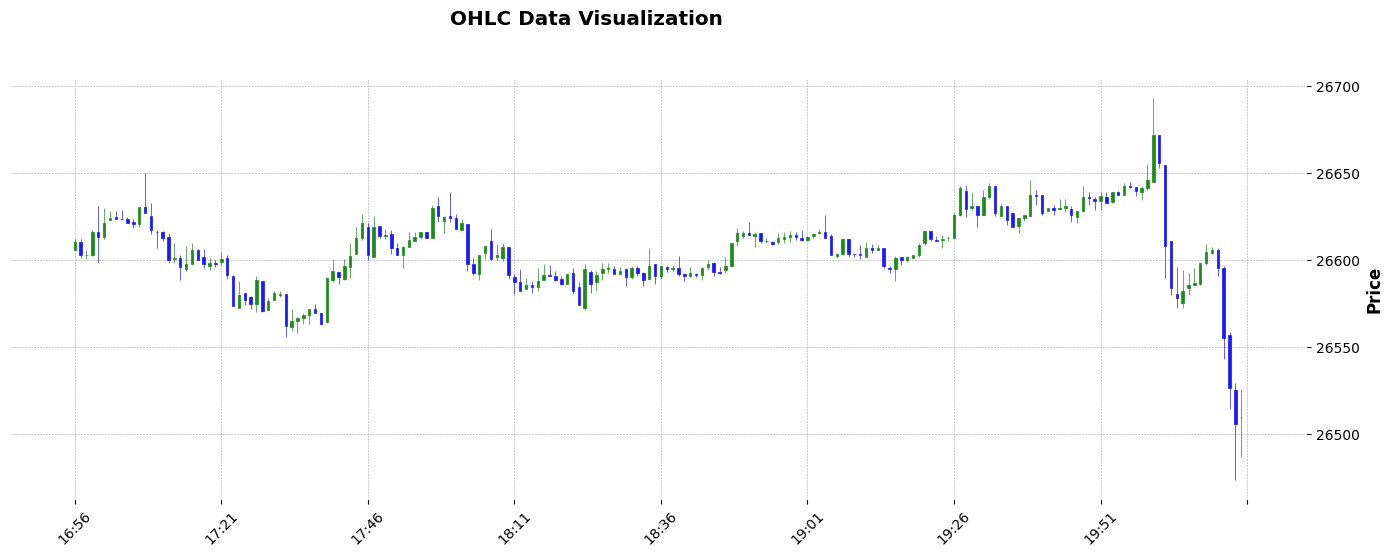

In [12]:
import mplfinance as mpf

def plot_ohlc(data_subset):
    """
    Plots OHLC data passed in as a subset DataFrame.

    Parameters:
    - data_subset: A DataFrame slice containing OHLC data, indexed by 'Open time'.
    """
    # Define custom style for the candlestick plot
    custom_style = mpf.make_mpf_style(
        base_mpf_style='charles',  # Base style
        marketcolors=mpf.make_marketcolors(
            up='green',    # Color for upward (bullish) candles
            down='blue',   # Color for downward (bearish) candles
            wick={'up': 'green', 'down': 'blue'},  # Customize wick colors
            edge={'up': 'green', 'down': 'blue'},  # Customize edge (outline) colors
        )
    )

    # Plot the candlestick chart for the OHLC data subset
    mpf.plot(data_subset, type='candle', style=custom_style, volume=False, title="OHLC Data Visualization", figsize=(18, 6))
    plt.show()

# Create subset outside the function
start_index = 4100000
num_points = 200
data_subset = coinbase_data.iloc[start_index:start_index + num_points].copy()

if data_subset.index.name != 'Open time':
    data_subset.set_index('Open time', inplace=True)
    
# Plot the subset
plot_ohlc(data_subset)

# Fixing Broken Data
While most exchanges provide consistent data, Bitstamp’s dataset includes erroneous data where Open values don’t align with the previous candle’s Close, causing discrepancies in candlestick patterns. To visualize this issue, we’ll plot both Coinbase and Bitstamp data for the same time period. This will highlight the misalignment, helping us justify adjustments to Bitstamp data.

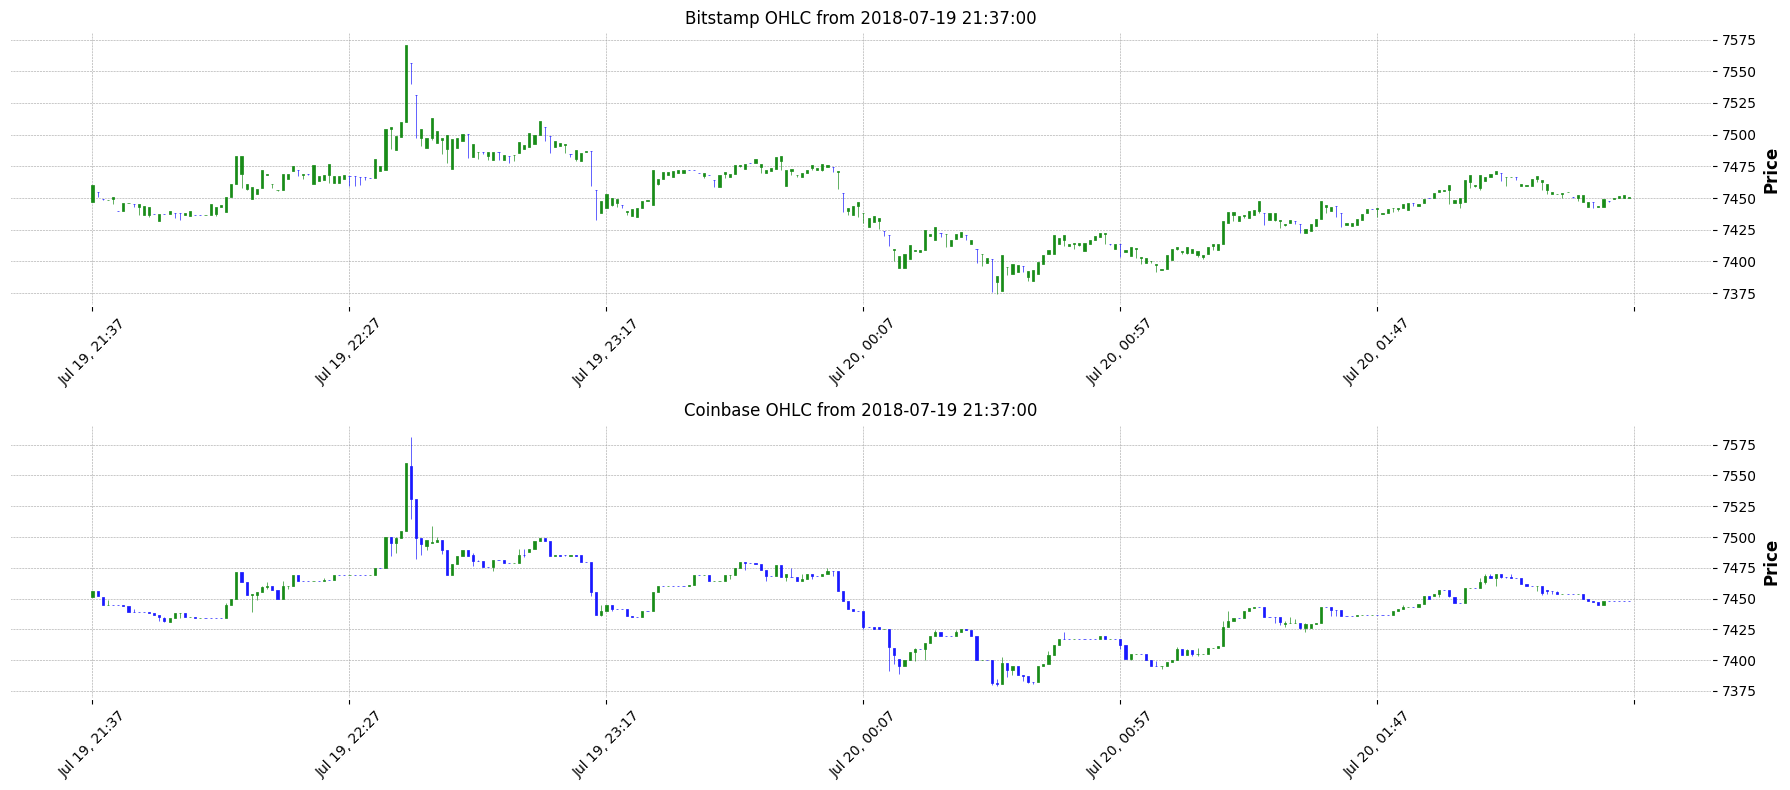

In [13]:
def plot_candlesticks_by_time(dataframes, start_time, width=300, figscale=1.5, figratio=(10, 6)):
    """
    Plots candlestick charts for multiple datasets (exchanges) starting from a specified 'Open time'.
    
    Parameters:
    - dataframes: List of tuples, each containing the name of the dataset (e.g., exchange name) and a DataFrame with OHLC data.
    - start_time: Start 'Open time' (string or pd.Timestamp) to slice the data for plotting.
    - width: Number of data points to plot from the start_time.
    - figscale: Scale factor for the overall figure size.
    - figratio: Width and height ratio for the figure, tuple format.
    """
    start_time = pd.to_datetime(start_time)

    # Filter dataframes for the requested start_time and width
    filtered_data = []
    for name, df in dataframes:
        # Ensure 'Open time' is datetime format and set as index only if not already the index
        if df.index.name != 'Open time':
            df['Open time'] = pd.to_datetime(df['Open time'])
            df.set_index('Open time', inplace=True)

        # Select data starting from 'start_time' and take 'width' rows
        if start_time in df.index:
            ohlc_subset = df.loc[start_time:].iloc[:width]
            filtered_data.append((name, ohlc_subset))
        else:
            print(f"No data for {name} at the requested start time.")

    # If no data is available for the specified start_time, stop execution
    if not filtered_data:
        print("No datasets contain data for the specified time range.")
        return

    # Set up subplots with dimensions based on the number of dataframes
    num_plots = len(filtered_data)
    fig, axes = plt.subplots(num_plots, 1, figsize=(figratio[0] * figscale, figratio[1] * figscale))

    # Ensure axes is a list even if there’s only one subplot
    if num_plots == 1:
        axes = [axes]

    # Loop through each filtered DataFrame and plot the candlestick chart
    for i, (name, df_subset) in enumerate(filtered_data):
        # Define custom colors for candlestick chart
        custom_style = mpf.make_mpf_style(
            base_mpf_style='charles',
            marketcolors=mpf.make_marketcolors(
                up='green', down='blue',
                wick={'up': 'green', 'down': 'blue'},
                edge={'up': 'green', 'down': 'blue'},
            )
        )

        # Plot on each subplot
        mpf.plot(df_subset, type='candle', style=custom_style, ax=axes[i], volume=False)
        axes[i].set_title(f'{name} OHLC from {start_time}')

    plt.tight_layout()
    plt.show()

# List of tuples, where each tuple is (name, DataFrame) for the dataset
dataframes = [
    ('Bitstamp', bitstamp_data),
    ('Coinbase', coinbase_data)
]

# Define the start time and number of data points to plot
start_time = '2018-07-19 21:37:00'
plot_candlesticks_by_time(dataframes, start_time, width=300, figscale=1, figratio=(18, 8))

As we can see from the above, Bitstamp's data mostly matches the profile of Coinbase's data (as well as the other exchanges), however, all the candles are green without the typical blue bear candle when price moves down. We can fix this issue and clean Bitstamp's data by setting a condition that the Open of the next candle should always equal the Close of the previous candle. This 'should' always be the case in OHLC data anyway, below we will fix this using a function we develop. We'll also use our dataframe diagnostic tool to see what this transformation does to our data overall.

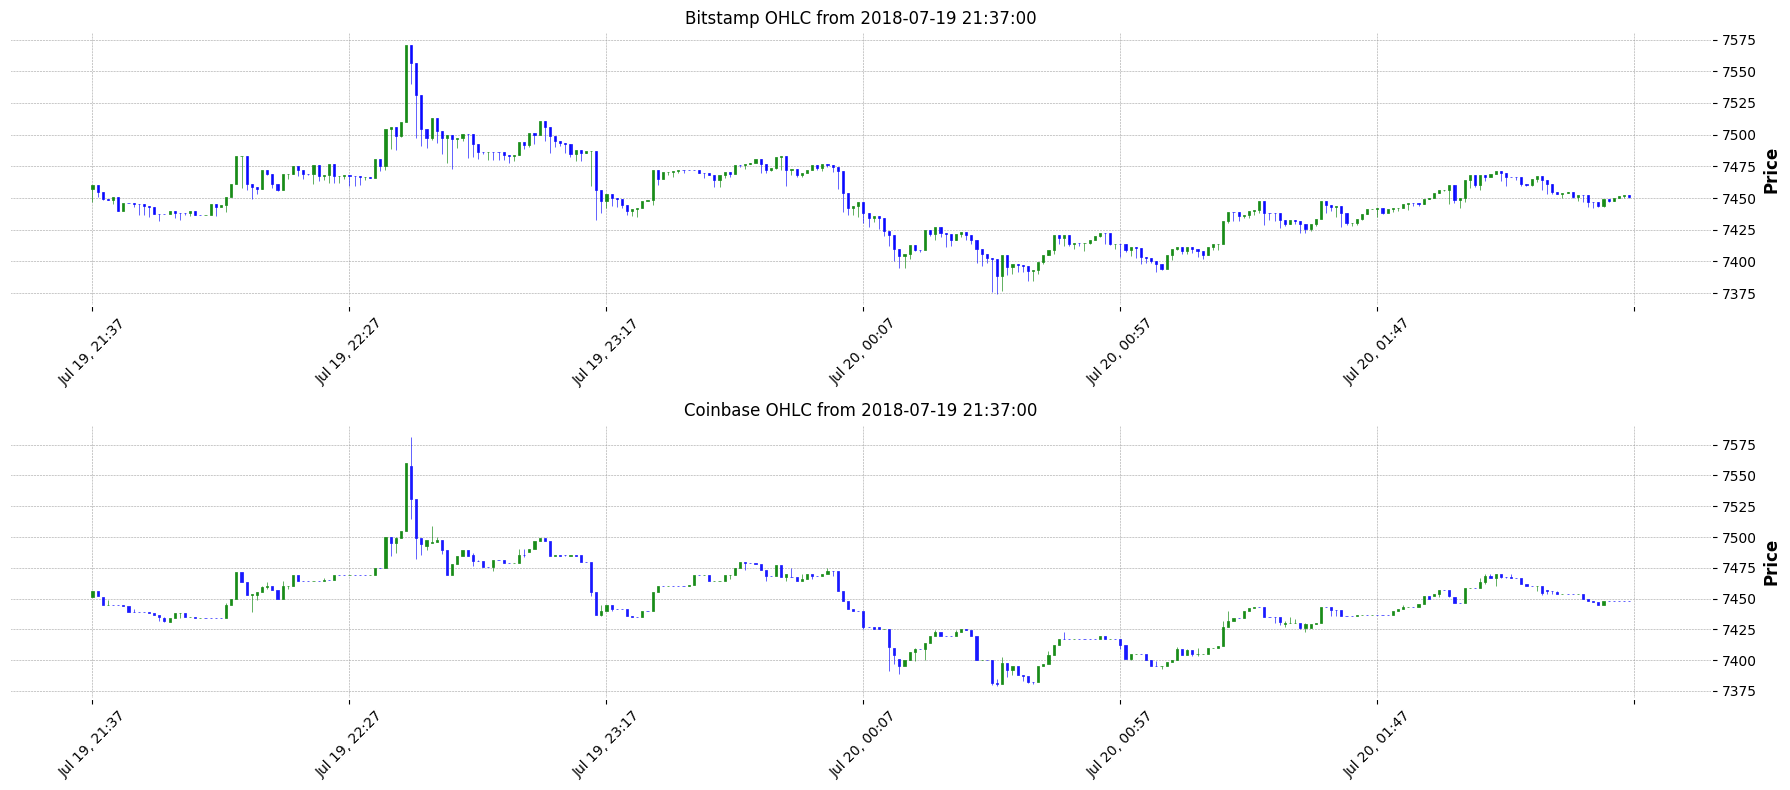

--- DataFrame Diagnostics ---
Start 'Open time': 2011-08-18 12:37:00, End 'Open time': 2024-10-26 22:04:00
Size: 6938490 rows
Total NaNs: 0
Columns with NaNs: None
Rows with NaNs: 0
Number of discontinuities in 'Open time': 2
Discontinuities range from 'Open time': 2024-10-26 15:00:00 to 'Open time': 2024-10-26 15:20:00
Number of duplicate rows: 0

Detected 2 data gaps:
Gap 1: Start Time 2024-10-26 15:00:00, End Time 2024-10-26 15:00:00, Gap Size: 0 days 00:00:00
Gap 2: Start Time 2024-10-26 15:20:00, End Time 2024-10-26 15:20:00, Gap Size: 0 days 00:00:00

--- OHLC Integrity Check ---
Invalid 'High' values: 2552531 rows
Invalid 'Low' values: 745051 rows


In [14]:
def fix_open_close_alignment(df):
    first_open_value = df.loc[df.index[0], 'Open']
    df_fixed = df.copy()  
    df_fixed['Open'] = df_fixed['Close'].shift(1)
    df_fixed.loc[df_fixed.index[0], 'Open'] = first_open_value

    return df_fixed

bitstamp_data = fix_open_close_alignment(bitstamp_data)

dataframes = [
    ('Bitstamp', bitstamp_data),
    ('Coinbase', coinbase_data)
]

plot_candlesticks_by_time(dataframes, start_time, width=300, figscale=1, figratio=(18, 8))

coinbase_data.reset_index(inplace=True, names='Open time')
bitstamp_data.reset_index(inplace=True, names='Open time')
dataframe_diagnostics(bitstamp_data)

**Open-Close (OC) Alignment and High/Low Adjustments**

With Bitstamp's data adjusted to ensure consistent Open-Close alignment between consecutive candles, we now need to address an issue with invalid High and Low values. This occurs because, in about 30% of candles, adjusting the Open value to match the Close of the previous candle results in the Open moving outside the original High or Low range. To maintain integrity, we adjust each candle’s High and Low values to reflect the true maximum and minimum within that candle's OHLC values.

**Why Adjust High and Low?**

Since only the Open values are being altered to enforce Open-Close alignment, this requires adjusting only one value per candle. For example, if the OHLC was (1, 4, 0, 2) and we move the Open to 5 to match the previous candles Close value, our new OHLC is (5, 4, 0, 2). Here, the High (4) is no longer the largest value, so we adjust it to reflect the highest price within the candle, resulting in (5, 5, 0, 2).

**Justification**

Bitstamp’s data arrives with this misalignment, and requiring the Open of one candle to equal the previous candle’s Close ensures continuity in price over time – a reasonable and expected standard. When the Open adjustment crosses a High/Low boundary, setting Highs/Lows to reflect this change is also logical. If we intend to train machine learning models, these requirements help maintain data consistency, ensuring that models can learn from clean and reliable patterns i.e. that Close values equal subsequent Open's and that the High/Low are always the largest/smallest value in a candle.

In the cell below, we'll fix our invalid highs and lows and update our fix_open_close_alignment function to include this fix for future use.

In [16]:
bitstamp_data['High'] = bitstamp_data[['Open', 'Close', 'High', 'Low']].max(axis=1)
bitstamp_data['Low'] = bitstamp_data[['Open', 'Close', 'High', 'Low']].min(axis=1)
dataframe_diagnostics(bitstamp_data)

def fix_open_close_alignment(df):    
    first_open_value = df.loc[df.index[0], 'Open']
    df_fixed = df.copy()  
    df_fixed['Open'] = df_fixed['Close'].shift(1)
    df_fixed.loc[df_fixed.index[0], 'Open'] = first_open_value

    df_fixed['High'] = df_fixed[['Open', 'Close', 'High', 'Low']].max(axis=1)
    df_fixed['Low'] = df_fixed[['Open', 'Close', 'High', 'Low']].min(axis=1)

    return df_fixed

--- DataFrame Diagnostics ---
Start 'Open time': 2011-08-18 12:37:00, End 'Open time': 2024-10-26 22:04:00
Size: 6938490 rows
Total NaNs: 0
Columns with NaNs: None
Rows with NaNs: 0
Number of discontinuities in 'Open time': 2
Discontinuities range from 'Open time': 2024-10-26 15:00:00 to 'Open time': 2024-10-26 15:20:00
Number of duplicate rows: 0

Detected 2 data gaps:
Gap 1: Start Time 2024-10-26 15:00:00, End Time 2024-10-26 15:00:00, Gap Size: 0 days 00:00:00
Gap 2: Start Time 2024-10-26 15:20:00, End Time 2024-10-26 15:20:00, Gap Size: 0 days 00:00:00

--- OHLC Integrity Check ---
Invalid 'High' values: 0 rows
Invalid 'Low' values: 0 rows


# Addressing Gaps with Centered Moving Average Imputation

When aggregating data from multiple exchanges—especially for early periods with fewer sources—we encounter gaps in individual exchanges' data that disrupt the continuity of the combined dataset. For example, if one exchange has a gap in its data, the averaged OHLC values reflect only the remaining exchanges. This inconsistency can lead to abrupt jumps in averaged values if the two exchanges have very different prices at the time, creating an unrealistic volatility profile. The problem compounds when gaps appear in sequence across exchanges, causing rapid fluctuations between the single-exchange values and the multi-exchange averages.

In the following cell, we’ll demonstrate the impact of these gaps on the averaged data, highlighting how they cause sharp price jumps and subsequently we will show how this can be addressed.

In [17]:
print(f"bitfinex_data: {bitfinex_data['Open time'].min()} to {bitfinex_data['Open time'].max()}")
print(f"coinbase_data: {coinbase_data['Open time'].min()} to {coinbase_data['Open time'].max()}\n")
print("Bitfinex Diagnostics:")
dataframe_diagnostics(bitfinex_data, max_gaps_to_print=0)
print("\nCoinbase Diagnostics:")
dataframe_diagnostics(coinbase_data, max_gaps_to_print=20)

bitfinex_data: 2013-07-19 00:05:00 to 2024-10-26 22:04:00
coinbase_data: 2015-07-20 21:37:00 to 2024-10-26 22:04:00

Bitfinex Diagnostics:
--- DataFrame Diagnostics ---
Start 'Open time': 2013-07-19 00:05:00, End 'Open time': 2024-10-26 22:04:00
Size: 4968480 rows
Total NaNs: 0
Columns with NaNs: None
Rows with NaNs: 0
Number of discontinuities in 'Open time': 342393
Discontinuities range from 'Open time': 2013-07-19 00:05:00 to 'Open time': 2024-10-26 22:01:00
Number of duplicate rows: 0

Detected 342393 data gaps:
... and 342393 more gaps are redacted for conciseness.

--- OHLC Integrity Check ---
Invalid 'High' values: 0 rows
Invalid 'Low' values: 0 rows

Coinbase Diagnostics:
--- DataFrame Diagnostics ---
Start 'Open time': 2015-07-20 21:37:00, End 'Open time': 2024-10-26 22:04:00
Size: 4814374 rows
Total NaNs: 0
Columns with NaNs: None
Rows with NaNs: 0
Number of discontinuities in 'Open time': 39435
Discontinuities range from 'Open time': 2015-07-20 22:26:00 to 'Open time': 2024-

**Creating a Weighted Average Dataset and Analyzing Gap Effects**

In this section, we'll create a weighted average dataset using data from **Bitstamp** and **Coinbase**. Our goal is to analyze how data gaps affect an averaged dataset and explore how imputation techniques can help.

We'll begin by examining the impact of gaps on the combined dataset. Specifically, we’ll look at the last eight gaps in Coinbase’s data, marking these gap regions on our plot for reference. Note that while we’re only marking Coinbase’s gaps, Bitfinex may also have gaps, which could lead to other candles being adjusted that aren’t explicitly marked.

To further analyze the effect of data continuity, we'll take the same two datasets and impute the missing values using moving averages before combining them. This will allow us to plot two OHLC candlestick charts side by side: one with imputed values and one with gaps. By comparing these, we’ll gain insight into the effect of imputation on data continuity and volatility in our weighted average.

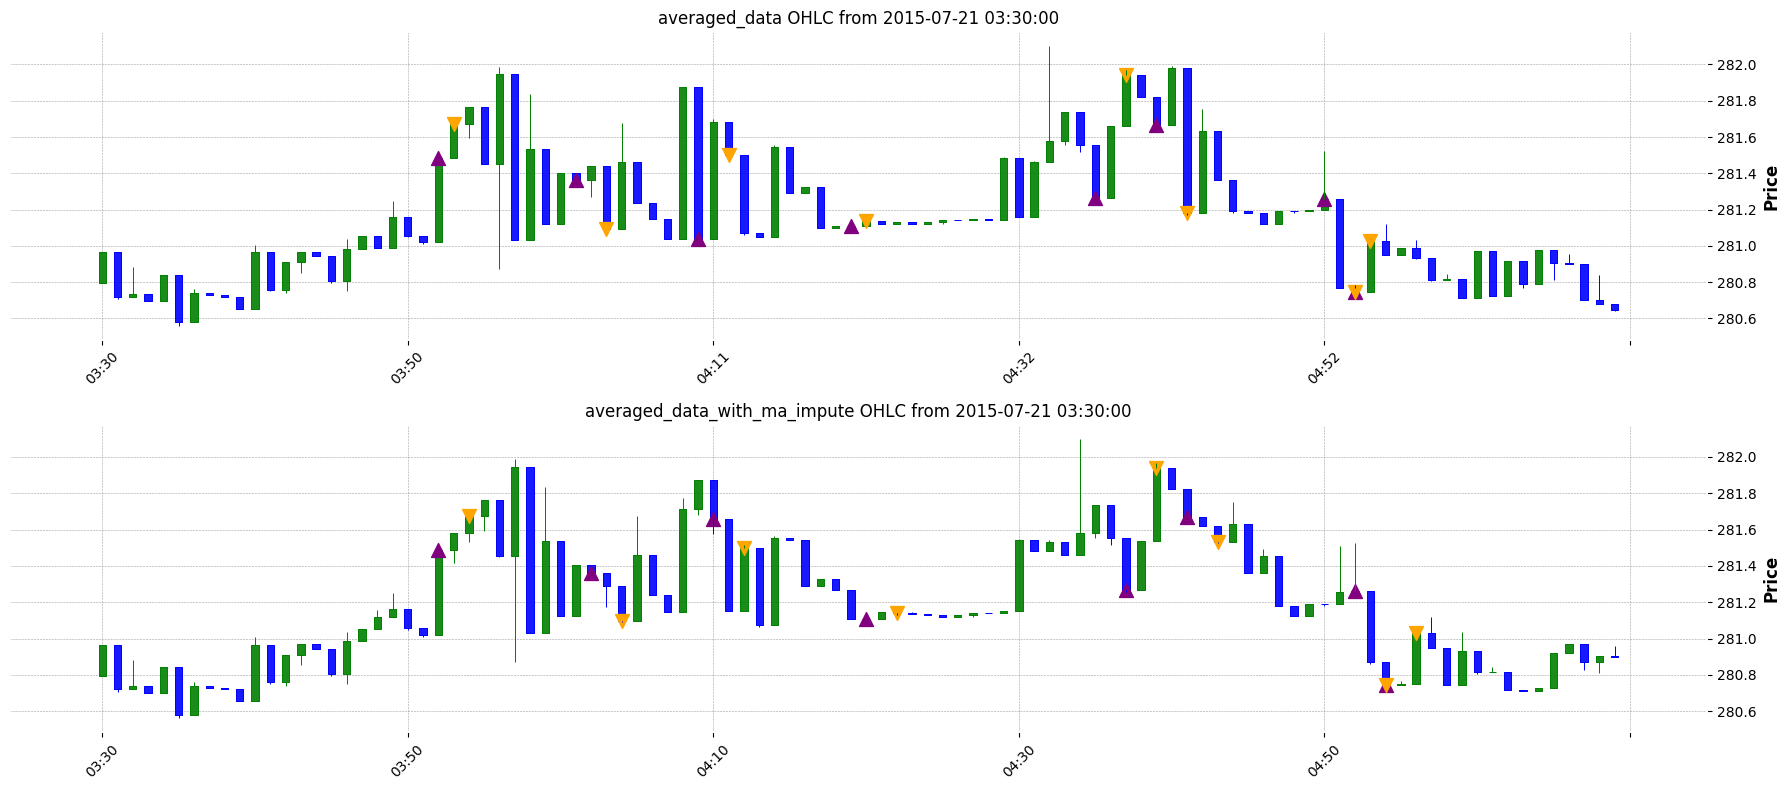

In [19]:
import numpy as np

def average_datasets_with_weighted_mean(datasets):
    """
    Calculate the weighted mean of 'Open', 'High', 'Low', and 'Close' values across multiple datasets, using volume as the weight.
    
    Purpose:
    - This function combines OHLC (Open, High, Low, Close) data from multiple sources by averaging these values with weights
      based on trading volume. By averaging, we get a more representative value of the market across different exchanges.
    
    Process:
    - For each timestep, the weighted average is calculated across all datasets.
    - If the weighted mean calculation yields NaN values (e.g., if there's zero volume for all exchanges at a certain timestep),
      those values are replaced by the simple mean for that timestep, ensuring no gaps remain in the combined data.

    Args:
        datasets (list of pd.DataFrame): List of DataFrames containing OHLC data for each exchange.

    Returns:
        pd.DataFrame: A DataFrame with the averaged OHLC data over the entire time period.
    """
    # Ensure 'Open time' is the index for each dataset, which is necessary for merging
    filtered_data_list = []
    for i, dataset in enumerate(datasets):
        if dataset.index.name != 'Open time':
            dataset = dataset.set_index('Open time')
        filtered_data_list.append(dataset)
    
    # Merge all datasets on 'Open time' using an outer join to include all timestamps from each dataset
    combined_data = pd.concat(filtered_data_list, axis=1, keys=[f'Dataset_{i+1}' for i in range(len(datasets))], join='outer')
    
    # Initialize an empty DataFrame for the final averaged data
    averaged_data = pd.DataFrame(index=combined_data.index)
    
    # Calculate the volume-weighted average for each OHLC column
    for col in ['Open', 'High', 'Low', 'Close']:
        # Extract OHLC and Volume columns from each dataset
        ohlc_columns = combined_data.xs(col, axis=1, level=1)
        volume_columns = combined_data.xs('Volume', axis=1, level=1)
        
        # Calculate the weighted average
        weighted_avg = (ohlc_columns * volume_columns).sum(axis=1) / volume_columns.sum(axis=1)
        averaged_data[col] = weighted_avg
    
    # Impute any NaN values in the averaged data with a simple mean across datasets
    for col in ['Open', 'High', 'Low', 'Close']:
        nan_rows = averaged_data[col].isna()
        if nan_rows.any():
            simple_mean = combined_data.xs(col, axis=1, level=1).mean(axis=1)
            averaged_data.loc[nan_rows, col] = simple_mean[nan_rows]
    
    # Reset the index for consistency, so 'Open time' is back as a column
    averaged_data.reset_index(inplace=True)
    
    return averaged_data


def plot_candlesticks_with_gaps_by_time(dataframes, start_time, width=300, figscale=1.5, figratio=(10, 6), gaps=None):
    """
    Plot candlestick charts for multiple datasets with markers to highlight data gaps.

    Purpose:
    - This function displays OHLC candlestick charts for each dataset, allowing for easy comparison between exchanges.
      It highlights gaps in the data by marking the start and end points of each gap, helping to visualize missing data.

    Parameters:
    - dataframes: List of tuples, where each tuple contains the dataset name and its OHLC DataFrame.
    - start_time: The start time ('Open time') for plotting data (string or pd.Timestamp).
    - width: Number of data points to plot from the start time.
    - figscale: Scale factor for the overall figure size.
    - figratio: Width and height ratio for the figure.
    - gaps: List of tuples representing gaps, each with ('Gap Start Time', 'Gap End Time').
    """
    # Ensure start_time is in datetime format
    start_time = pd.to_datetime(start_time)
    filtered_data = []
    
    # Filter each DataFrame based on the start time and the specified width
    for name, df in dataframes:
        if df.index.name != 'Open time':
            df['Open time'] = pd.to_datetime(df['Open time'])
            df.set_index('Open time', inplace=True)

        # Slice the data from the start time to get the desired width
        if start_time in df.index:
            ohlc_subset = df.loc[start_time:].iloc[:width]
            filtered_data.append((name, ohlc_subset))
        else:
            print(f"No data for {name} at the requested start time.")

    # Exit if no data was available for the specified time range
    if not filtered_data:
        print("No datasets contain data for the specified time range.")
        return

    # Set up subplots for each dataset
    num_plots = len(filtered_data)
    fig, axes = plt.subplots(num_plots, 1, figsize=(figratio[0] * figscale, figratio[1] * figscale))
    if num_plots == 1:
        axes = [axes]

    for i, (name, df_subset) in enumerate(filtered_data):
        # Set the color scheme for candlesticks
        custom_style = mpf.make_mpf_style(
            base_mpf_style='charles',
            marketcolors=mpf.make_marketcolors(
                up='green', down='blue',
                wick={'up': 'green', 'down': 'blue'},
                edge={'up': 'green', 'down': 'blue'},
            )
        )

        # Initialize arrays to mark gaps with arrows
        gap_start_values = np.full(df_subset.shape[0], np.nan)
        gap_end_values = np.full(df_subset.shape[0], np.nan)

        # Mark the gaps on the plot
        if gaps:
            for gap_start, gap_end in gaps:
                gap_start, gap_end = pd.to_datetime(gap_start), pd.to_datetime(gap_end)
                if gap_start in df_subset.index:
                    gap_start_values[df_subset.index.get_loc(gap_start)] = df_subset.loc[gap_start, 'Close']
                if gap_end in df_subset.index:
                    gap_end_values[df_subset.index.get_loc(gap_end)] = df_subset.loc[gap_end, 'Close']

        # Add gap markers to the plot
        addplot_gap_start = mpf.make_addplot(gap_start_values, scatter=True, markersize=100, marker='^', color='purple', ax=axes[i])
        addplot_gap_end = mpf.make_addplot(gap_end_values, scatter=True, markersize=100, marker='v', color='orange', ax=axes[i])

        # Plot the candlestick chart
        mpf.plot(
            df_subset,
            type='candle',
            style=custom_style,
            addplot=[addplot_gap_start, addplot_gap_end],
            ax=axes[i],
            volume=False
        )
        axes[i].set_title(f'{name} OHLC from {start_time}')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    

def process_and_impute_ohlc_data_with_ma(df, ma_window=3):
    """
    Impute missing OHLC data with moving averages to create a complete dataset.

    Purpose:
    - This function fills small gaps in OHLC data by calculating a moving average over each OHLC column.
      This prevents data gaps from creating artificial volatility, particularly when combining data from
      multiple exchanges.

    Process:
    - Ensures a continuous time index at one-minute intervals, filling missing timestamps with NaNs.
    - Applies a moving average to fill small gaps, then removes remaining NaNs (for larger gaps).
    - Ensures all values are rounded and consistent for analysis.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing OHLC data.
    - ma_window (int): Window size for moving average (default=3).

    Returns:
    - pd.DataFrame: Imputed OHLC data with NaNs filled by the moving average.
    """
    # Remove duplicate indices, keeping only the first occurrence
    if df.index.duplicated().any():
        df = df[~df.index.duplicated(keep='first')]
        
    # Ensure 'Open time' is the index
    if df.index.name != 'Open time':
        df.set_index('Open time', inplace=True)
    
    # Create a continuous time index with one-minute frequency
    full_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='min')
    df = df.reindex(full_time_index)
    
    # Apply centered moving average to each OHLC column
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        ma_col_name = f'MA_{col}'
        df[ma_col_name] = df[col].rolling(center=True, window=ma_window, min_periods=1).mean()

    # Impute missing values with the moving average
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        ma_col = f'MA_{col}'
        df[col] = df[col].fillna(df[ma_col])

    # Remove temporary columns and NaNs, rounding values
    df.drop(columns=[f'MA_{col}' for col in ['Open', 'High', 'Low', 'Close', 'Volume']], inplace=True)
    df.dropna(inplace=True)
    df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].round(2)
    df.reset_index(inplace=True, names='Open time')
    
    return df


# Define data gap intervals for Coinbase, with each tuple representing start and end times
# These will be marked on the plot to visualize where data is missing.
gaps = [
    ("2015-07-21 03:09:00", "2015-07-21 03:11:00"),
    ("2015-07-21 03:52:00", "2015-07-21 03:54:00"),
    ("2015-07-21 04:02:00", "2015-07-21 04:04:00"),
    ("2015-07-21 04:10:00", "2015-07-21 04:12:00"),
    ("2015-07-21 04:20:00", "2015-07-21 04:22:00"),
    ("2015-07-21 04:37:00", "2015-07-21 04:39:00"),
    ("2015-07-21 04:41:00", "2015-07-21 04:43:00"),
    ("2015-07-21 04:52:00", "2015-07-21 04:54:00"),
    ("2015-07-21 04:54:00", "2015-07-21 04:56:00")
]

# Combine Bitfinex and Coinbase datasets using a volume-weighted average
datasets_to_average = [bitfinex_data, coinbase_data]
averaged_data = average_datasets_with_weighted_mean(datasets_to_average)
averaged_data = fix_open_close_alignment(averaged_data)

# Impute small gaps in each dataset using a moving average before re-averaging.
for i in range(len(datasets_to_average)):
    datasets_to_average[i] = process_and_impute_ohlc_data_with_ma(datasets_to_average[i], ma_window=3)

# Re-calculate the weighted average after imputation to see how filling gaps affects the combined data.
averaged_data_with_ma_impute = average_datasets_with_weighted_mean(datasets_to_average)
averaged_data_with_ma_impute = fix_open_close_alignment(averaged_data_with_ma_impute)

# Prepare datasets with and without imputation for plotting and comparison.
dataframes = [
    ('averaged_data', averaged_data),
    ('averaged_data_with_ma_impute', averaged_data_with_ma_impute)
]

# Plot the two datasets starting from a specific time, marking data gaps for reference.
start_time = '2015-07-21 03:30:00'
plot_candlesticks_with_gaps_by_time(
    dataframes,  # Datasets to plot
    start_time,  # Start time for plotting
    width=100,   # Number of data points to display
    figscale=1,  # Scale for figure size
    figratio=(18, 8),  # Width and height ratio for plot
    gaps=gaps  # Highlighted gaps
)


**Insights from Comparing Imputed vs. Non-Imputed OHLC Data**

In addition to smoother transitions, the imputed dataset offers the following improvements:

1.     Reduction in Alternating Large Bars:
    *         In the non-imputed dataset (top plot), there are sequences of large alternating candles, particularly noticeable in the regions around 4:10-4:11 and 4:30-4:32. These abrupt changes are caused by gaps in one dataset, leading to jumps in the combined values when only one exchange’s data is available.
    *         In the imputed dataset (bottom plot), these regions display a more natural progression of OHLC values, resulting in smoother, less volatile sequences without dramatic, artificial jumps.
    

2.     Expansion of the Time Axis:
    *         Imputing the gaps has introduced a few additional candles, effectively increasing data continuity and density in the imputed plot. By filling in smaller gaps, the time axis becomes more representative of continuous market activity, enhancing the dataset's usefulness for time-series analysis.

Conclusion:
By filling small gaps before averaging, we achieve a smoother, more reliable dataset with fewer unnatural spikes and a more consistent flow. This can improve the quality of downstream analysis and modeling by minimizing artificial volatility.

# Finalizing the Combined OHLC Index

Throughout this notebook, we’ve explored and addressed key challenges encountered with time series OHLC (Open, High, Low, Close) data from multiple exchanges. By understanding and resolving issues like data gaps, open-close misalignment, and exchange volume weighting, we’ve built a strong foundation for creating a robust, continuous OHLC dataset.

Now, we’re ready to bring together the techniques we’ve applied so far to generate a final, cohesive dataset that provides the most accurate and smooth representation of BTC/USD price movements across all sources.

**Steps to Create the Final Combined Index**

We will complete the following sequence of operations to create the final index dataset:

1.     **Open-Close (OC) Alignment for Bitstamp:**
    First, we address Bitstamp’s unique misalignment where the Open value does not align with the previous candle’s Close, which is required for continuity in time series data. Fixing this will ensure the Bitstamp dataset aligns with typical OHLC behavior and integrates smoothly with other datasets.

1.     **Impute Missing Values with Moving Average:**
    Each dataset contains gaps due to missing data points. To prevent these gaps from causing artificial volatility in the combined index, we use a centered moving average imputation for each dataset. This technique fills small gaps, improving continuity and ensuring consistent values over time, even when a single exchange dataset is briefly unavailable.

1.    **Volume-Weighted Averaging Across Datasets:**
    After ensuring data continuity within each dataset, we average the OHLC values across all sources using volume-weighted averages. This step ensures that exchanges with higher trading volume contribute more significantly to the index, creating a dataset that reflects broader market activity rather than favoring smaller exchanges. For any rows with zero volume across all exchanges, we impute those values with a simple mean to maintain a complete dataset.

1.     **Final Open-Close (OC) Alignment on the Combined Dataset:**
    Averaging the datasets may introduce minor open-close misalignments. To correct this, we perform one last OC alignment on the combined dataset, setting each candle’s Open to the previous candle’s Close. This ensures that our final index is free of any discontinuities, providing a smooth, continuous dataset ideal for time series analysis and model training.

**Conclusion**

This final dataset brings together data from all available exchanges in a continuous and coherent format. It reflects market-wide pricing with high fidelity and smooth transitions, making it a powerful resource for any subsequent analyses or models that rely on stable, gap-free time series data.

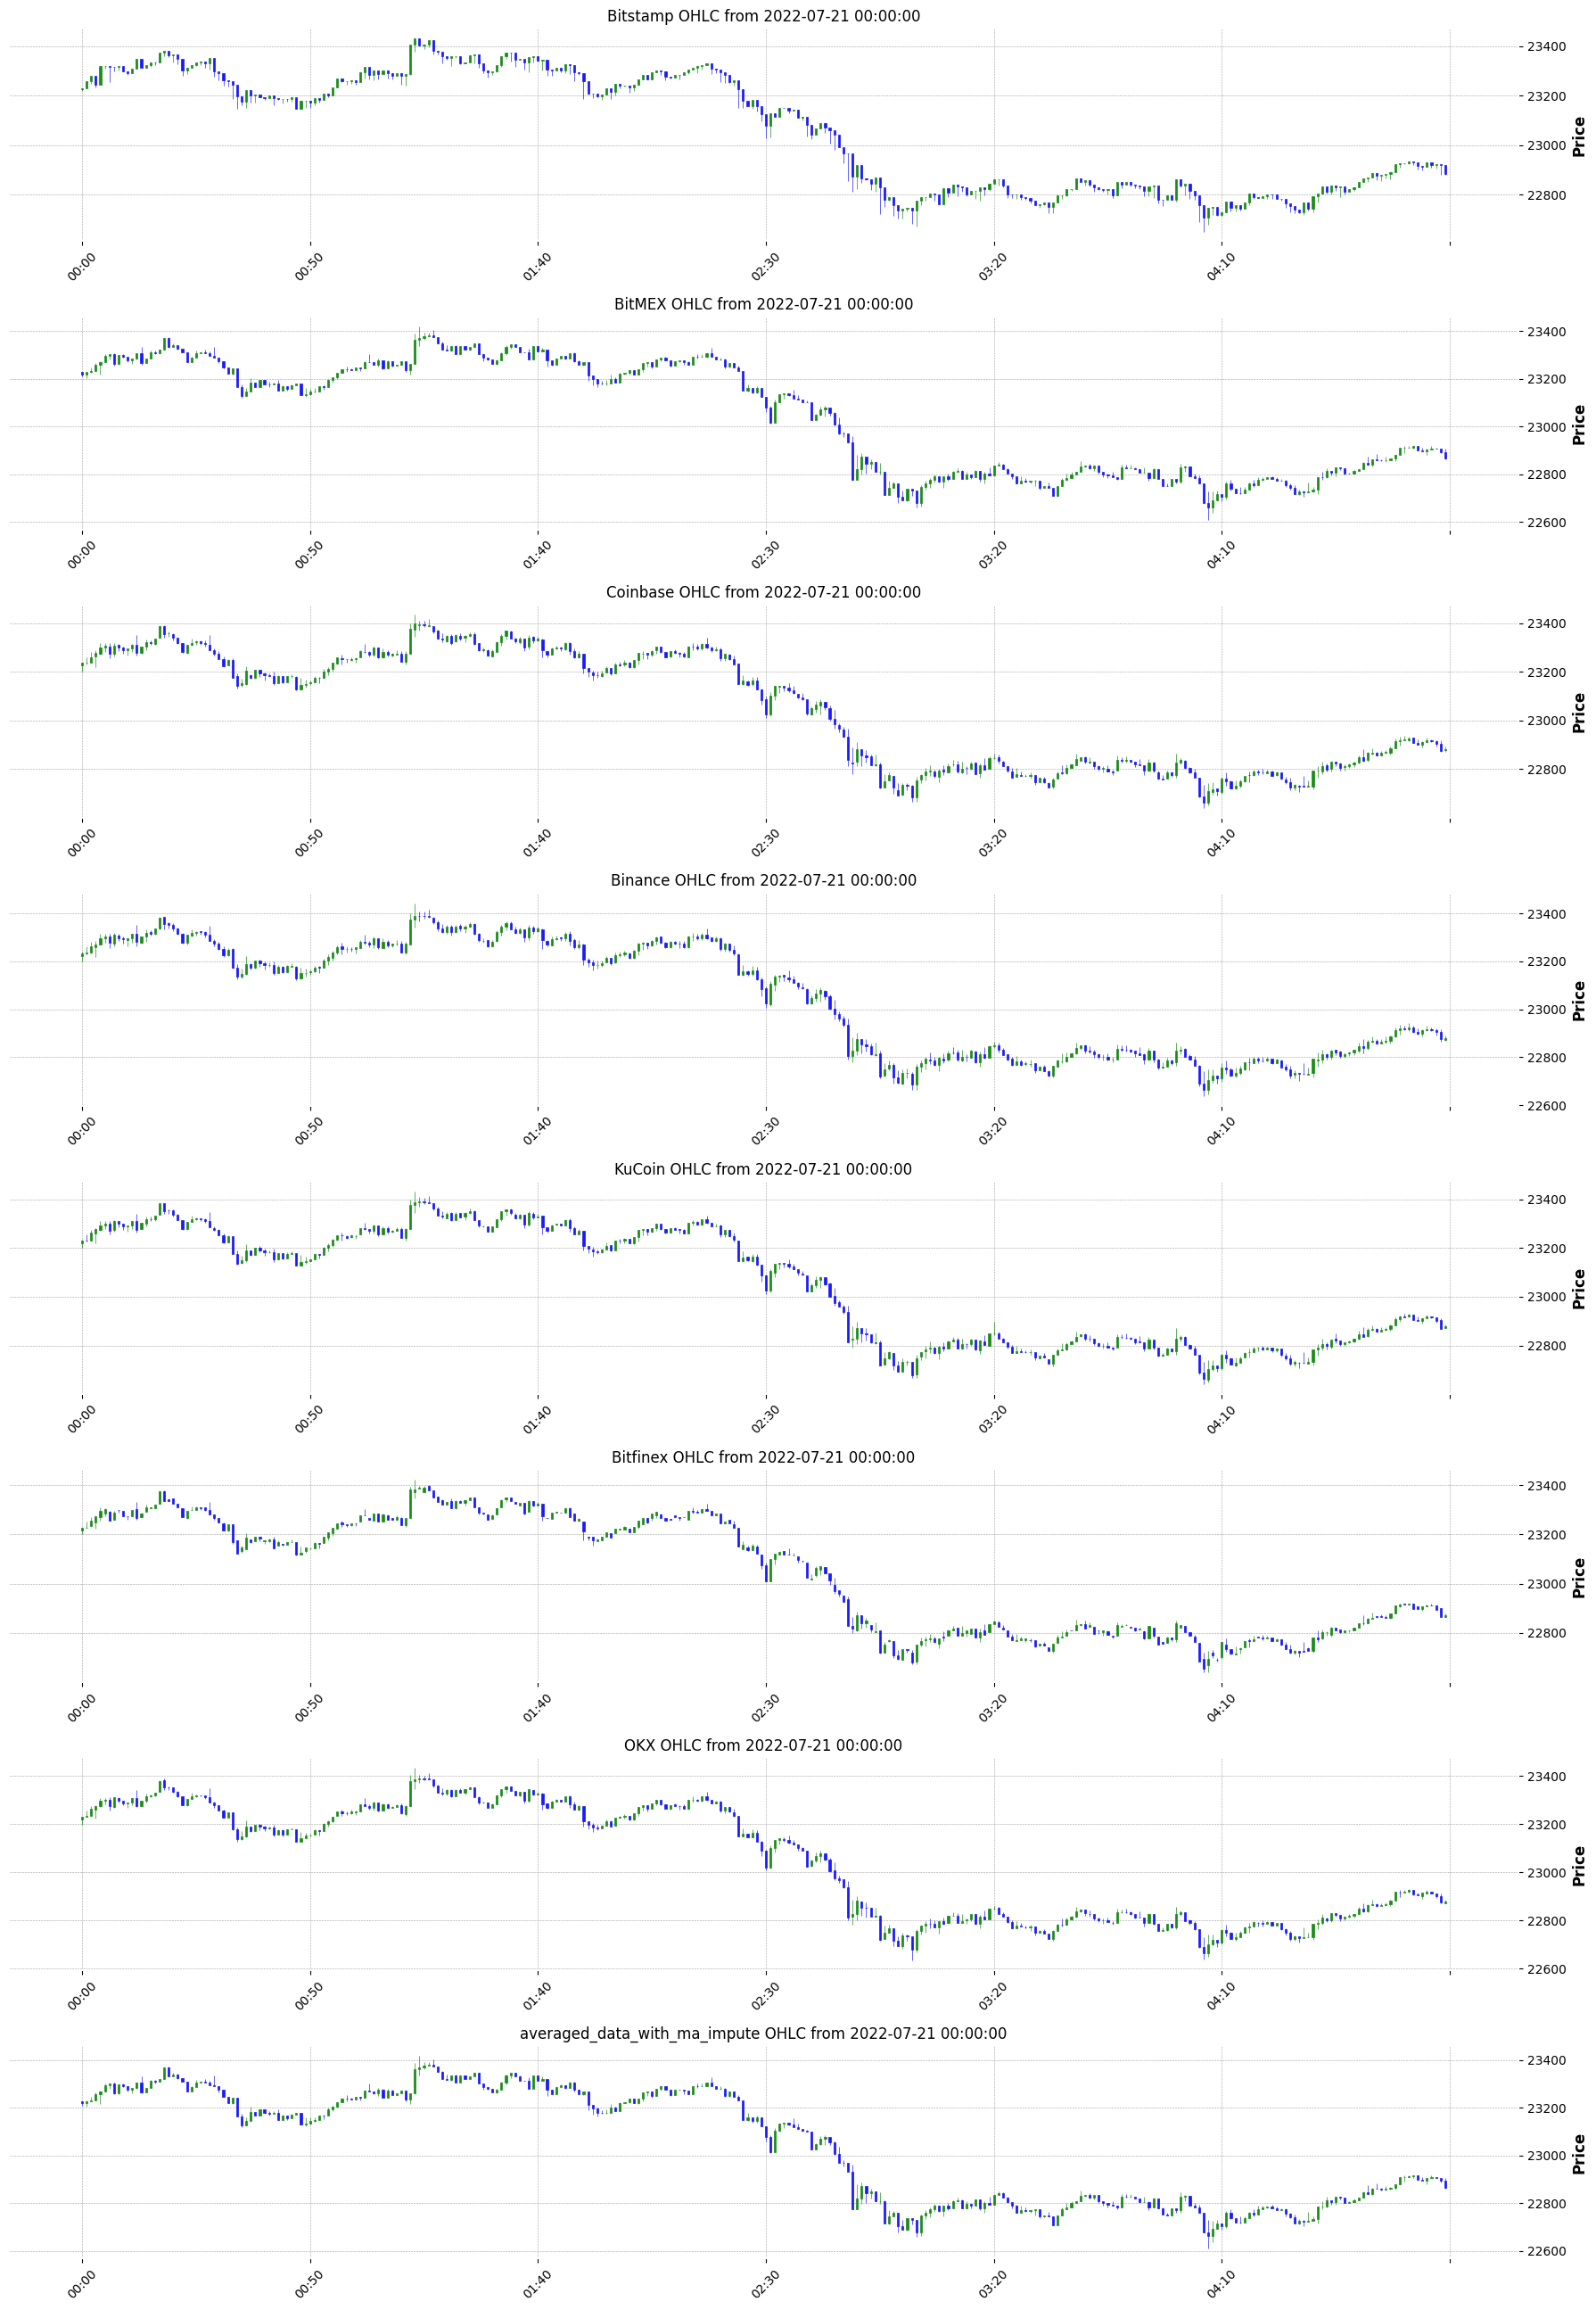

In [20]:
# Import each exchange dataset
bitstamp_data = datasets['BTCUSD_1m_Bitstamp.csv']
bitmex_data = datasets['BTCUSD_1m_BitMEX.csv']
coinbase_data = datasets['BTCUSD_1m_Coinbase.csv']
binance_data = datasets['BTCUSD_1m_Binance.csv']
kucoin_data = datasets['BTCUSD_1m_KuCoin.csv']
bitfinex_data = datasets['BTCUSD_1m_Bitfinex.csv']
okx_data = datasets['BTCUSD_1m_OKX.csv']

# Step 1: Fix Open-Close alignment on Bitstamp's data
bitstamp_data = fix_open_close_alignment(bitstamp_data)

# Step 2: Prepare the list of datasets to average
datasets_to_average = [bitstamp_data, bitmex_data, coinbase_data, binance_data, kucoin_data, bitfinex_data, okx_data]

# Step 3: Impute missing OHLC values using moving average for each dataset
for i in range(len(datasets_to_average)):
    datasets_to_average[i] = process_and_impute_ohlc_data_with_ma(datasets_to_average[i], ma_window=3)

# Step 4: Perform weighted average across all imputed datasets
averaged_data_with_ma_impute = average_datasets_with_weighted_mean(datasets_to_average)

# Step 5: Final Open-Close alignment on the combined dataset
averaged_data_with_ma_impute = fix_open_close_alignment(averaged_data_with_ma_impute)

# Step 6: Prepare dataframes for visualization
dataframes = [
    ('Bitstamp', bitstamp_data),
    ('BitMEX', bitmex_data),
    ('Coinbase', coinbase_data),
    ('Binance', binance_data),
    ('KuCoin', kucoin_data),
    ('Bitfinex', bitfinex_data),
    ('OKX', okx_data),
    ('averaged_data_with_ma_impute', averaged_data_with_ma_impute)
]

start_time = '2022-07-21 00:00:00'
plot_candlesticks_by_time(dataframes, start_time, width=300, figscale=1, figratio=(18, 26))

# Final Summary

With this notebook, we’ve constructed a high-quality, comprehensive BTC/USD dataset by integrating OHLC (Open, High, Low, Close) data from seven major exchanges—Bitstamp, BitMEX, Coinbase, Binance, KuCoin, Bitfinex, and OKX. Through meticulous data cleaning and processing, we have:

- **Eliminated Data Gaps:** We used centered moving average imputation to address small gaps, ensuring a continuous time series that mitigates artificial volatility caused by missing values.
- **Corrected Erroneous Values:** Each dataset was carefully checked for open-close misalignments, as well as for discrepancies in high and low values to maintain data integrity.
- **Constructed a Volume-Weighted Index:** By applying a volume-weighted averaging approach across all exchanges, we captured a balanced and market-representative view, giving higher weight to exchanges with larger trading volumes.

The result is a robust and accurate dataset, spanning the entire volume and pricing information from all exchanges in one continuous and clean format. This final, gap-free dataset is ideal for training machine learning models, as it reflects a holistic view of the BTC/USD market and provides a stable basis for reliable time series analysis and predictive modeling. This dataset now serves as a foundational asset for further analysis or advanced modeling techniques.